# Duygu Ider's MSc Thesis at HU Berlin - March, 2022
=> Financial Prediction Models & Trading Simulation

## Intro

Install and import libraries

In [2]:
pip install catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [ ]:
pip install lime

     |████████████████████████████████| 275 kB 4.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=aa30ab10afd6cea5c82ade502d325724384b00a9bad52125ec3648effec24151
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import warnings
warnings.filterwarnings('ignore')
# warnings.resetwarnings()

In [ ]:
pip install scikit-optimize

     |████████████████████████████████| 100 kB 3.5 MB/s 


In [ ]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import sklearn.metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from catboost import CatBoostRegressor
from skopt import BayesSearchCV
from skopt.plots import plot_convergence
from skopt.space import Real, Categorical, Integer
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np
import random
import time
import datetime
from pprint import pprint
import math
import matplotlib.dates as mdates
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from statsmodels.tsa.stattools import grangercausalitytests
from lime import lime_tabular

In [ ]:
from numpy import mean, std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, Perceptron, LinearRegression, Ridge, SGDRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, 
                              GradientBoostingRegressor, AdaBoostClassifier, StackingClassifier, 
                              RandomForestRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor)
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from matplotlib import pyplot
from google.colab import files, drive
# from skopt import BayesSearchCV

In [ ]:
pip install ta

  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28908 sha256=53711da70ecc733ae20f7b06f4921c241606d8b0521b196384c035ba8c103084
  Stored in directory: /root/.cache/pip/wheels/72/78/64/cc1c01506a1010a9845e9bd7c69333730f7174661228ea4f98
Successfully built ta


In [ ]:
import ta

## Data Load and Prep

Connect to Google Drive

In [ ]:
drive.mount('/drive')

Mounted at /drive


Define the name of the target variables: 1-day return for regression and 1-day return direction (pos/neg) for classification

In [ ]:
target = 'return_tmr'
target_c = 'return_tmr_classif'

Get data function: reads the tabular dataset for financial model, creates technical analysis features using daily prices, lags selected features and transforms the binary target by discretizing the continuous target variable.

In [ ]:
def get_data():
  if current_currency=="BTC":
    data = pd.read_excel("/drive/My Drive/Colab Notebooks/data_features.xlsx", index_col=0)
  elif current_currency=="ETH":
    data = pd.read_excel("/drive/My Drive/Colab Notebooks/data_features_eth.xlsx", index_col=0)
  
  data = data.drop(['sentiment_overall', 'count_total'],axis=1)
  features = data.columns.values

  # add technical features
  data = ta.add_all_ta_features(data, open="Open", high="High", low="Low", close="Close", volume="Volume")
  # fill empty values
  data = data.bfill()
  data = data.ffill()

  sentiment_feature_names = [*[feat for feat in features if "sentiment" in feat], *[feat for feat in features if "count" in feat]]

  # features to remove
  feat_remove = ['date','cryptocurrency', *np.setdiff1d(['Close_tmr', 'dif_tmr', 'return_tmr'], target)]
  features = np.setdiff1d(features, feat_remove)

  # separate features not to lag and to lag
  features_lag = features.copy()
  no_lag_feat = ['Open','High','Low','Adj Close',target, 
                *[feat for feat in data.columns.values if 'weekday' in feat],
                *sentiment_feature_names]
  features_lag = np.setdiff1d(features_lag, no_lag_feat)

  # lag features that are in the lag list
  data = lag_all_dataset(data.copy(), features_lag, 3)

  data = data.bfill()
  data = data.ffill()

  # create binary return feature for classification
  data = binary_target_classification(data.copy(), target, target_c, 2)

  return data, feat_remove

Test to see that the get_data() function works

In [ ]:
current_currency = 'BTC'
data, feat_remove = get_data()

View the data

In [ ]:
data

,date,Open,High,Low,Adj Close,return_tmr,Close_tmr,dif_tmr,cryptocurrency,sentiment_news,...,transac_per_block_0,transac_per_block_1,transac_per_block_2,volatility_index_0,volatility_index_1,volatility_index_2,volume_other_0,volume_other_1,volume_other_2,return_tmr_classif
0,2019-08-01,10077.442383,10446.919922,9922.019531,10399.668945,0.011395,10518.174805,118.505859,BTC,0.588235,...,2039.020811,2039.020811,2039.020811,30.596073,30.596073,30.596073,5965442642,5.965443e+09,5.965443e+09,1
1,2019-08-02,10402.042969,10657.953125,10371.013672,10518.174805,0.028860,10821.726562,303.551758,BTC,0.318182,...,2039.020811,2039.020811,2039.020811,30.596073,30.596073,30.596073,6159440229,5.965443e+09,5.965443e+09,1
2,2019-08-03,10519.278320,10946.781250,10503.504883,10821.726562,0.013719,10970.184570,148.458008,BTC,0.250000,...,2039.020811,2039.020811,2039.020811,30.596073,30.596073,30.596073,5697798687,6.159440e+09,5.965443e+09,1
3,2019-08-04,10821.632812,11009.207031,10620.278320,10970.184570,0.076158,11805.653320,835.468750,BTC,0.500000,...,2069.545327,2039.020811,2039.020811,30.596073,30.596073,30.596073,5238542572,5.697799e+09,6.159440e+09,1
4,2019-08-05,10960.735352,11895.091797,10960.735352,11805.653320,-0.027740,11478.168945,-327.484375,BTC,0.352941,...,2100.069843,2069.545327,2039.020811,30.596073,30.596073,30.596073,7765060287,5.238543e+09,5.697799e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,2022-02-11,43571.128906,43810.832031,42114.539062,42407.937500,-0.003855,42244.468750,-163.468750,BTC,-0.025641,...,1830.131785,1832.124160,1834.116535,92.035292,99.741230,106.526612,16043881065,1.862949e+10,1.395131e+10,0
926,2022-02-12,42412.300781,42992.550781,41852.574219,42244.468750,-0.001111,42197.515625,-46.953125,BTC,0.000000,...,1828.139410,1830.131785,1832.124160,88.041894,92.035292,99.741230,11254355757,1.604388e+10,1.862949e+10,0
927,2022-02-13,42236.566406,42693.054688,41950.941406,42197.515625,0.009228,42586.917969,389.402344,BTC,0.384615,...,1764.131347,1828.139410,1830.131785,82.906135,88.041894,92.035292,9054963563,1.125436e+10,1.604388e+10,1
928,2022-02-14,42157.398438,42775.777344,41681.957031,42586.917969,0.046688,44575.203125,1988.285156,BTC,-0.035714,...,1700.123285,1764.131347,1828.139410,78.340156,82.906135,88.041894,12164552172,9.054964e+09,1.125436e+10,1


In [ ]:
data.columns.tolist()

['date',
 'Open',
 'High',
 'Low',
 'Adj Close',
 'return_tmr',
 'Close_tmr',
 'dif_tmr',
 'cryptocurrency',
 'sentiment_news',
 'sentiment_twitter',
 'sentiment_reddit',
 'count_news',
 'count_reddit',
 'count_twitter',
 'weekday_Friday',
 'weekday_Monday',
 'weekday_Saturday',
 'weekday_Sunday',
 'weekday_Thursday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'volume_adi',
 'volume_obv',
 'volume_cmf',
 'volume_fi',
 'volume_em',
 'volume_sma_em',
 'volume_vpt',
 'volume_vwap',
 'volume_mfi',
 'volume_nvi',
 'volatility_bbm',
 'volatility_bbh',
 'volatility_bbl',
 'volatility_bbw',
 'volatility_bbp',
 'volatility_bbhi',
 'volatility_bbli',
 'volatility_kcc',
 'volatility_kch',
 'volatility_kcl',
 'volatility_kcw',
 'volatility_kcp',
 'volatility_kchi',
 'volatility_kcli',
 'volatility_dcl',
 'volatility_dch',
 'volatility_dcm',
 'volatility_dcw',
 'volatility_dcp',
 'volatility_atr',
 'volatility_ui',
 'trend_macd',
 'trend_macd_signal',
 'trend_macd_diff',
 'trend_sma_fast',
 'trend_

## Train-Test Plot

Plot the daily closing price and plot a vertical dashed line to separate train and test parts of the data, for each cryptocurrency. Only for visualization purposes

In [ ]:
df = data = pd.read_excel("/drive/My Drive/Colab Notebooks/data_features_eth.xlsx", index_col=0)
df2 = pd.read_excel("/drive/My Drive/Colab Notebooks/data_features.xlsx", index_col=0)

In [ ]:
df2 = data.copy()
# df2 is btc and df is eth

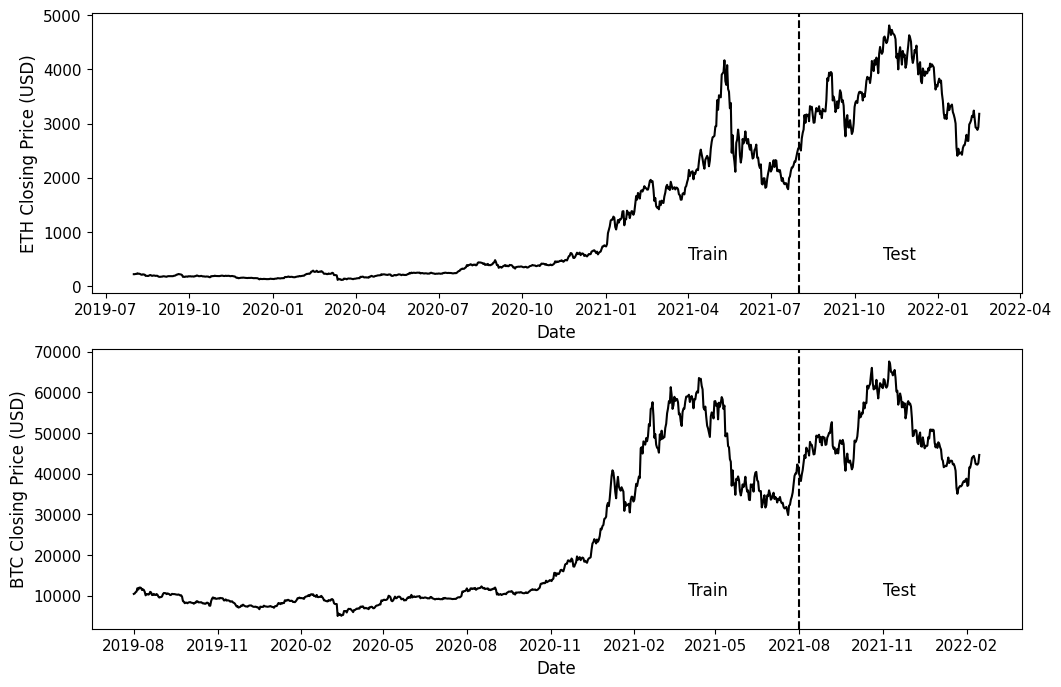

In [ ]:
df['date_dt'] = df.date.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')).values
df2['date_dt'] = df2.date.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')).values

fig, ax = plt.subplots(2)

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[2, 5, 8, 11]))

# plot ETH
ax[0].plot(df.date_dt, df.Close, color='black')
ax[0].axvline(x=datetime.datetime.strptime('2021-08-01', '%Y-%m-%d'), color='black', linestyle='--')
ax[0].set_xlabel("Date",fontsize=12)
ax[0].set_ylabel("ETH Closing Price (USD)",fontsize=12)

ax[0].text(datetime.datetime.strptime('2021-04-01', '%Y-%m-%d'), 500, 'Train', fontsize = 12)
ax[0].text(datetime.datetime.strptime('2021-11-01', '%Y-%m-%d'), 500, 'Test', fontsize = 12)

# plot BTC
ax[1].plot(df2.date_dt, df2.Close, color='black')
ax[1].set_ylabel("BTC Closing Price (USD)",fontsize=12)
ax[1].set_xlabel("Date",fontsize=12)

plt.axvline(x=datetime.datetime.strptime('2021-08-01', '%Y-%m-%d'), color='black', linestyle='--')

ax[1].text(datetime.datetime.strptime('2021-04-01', '%Y-%m-%d'), 10000, 'Train', fontsize = 12)
ax[1].text(datetime.datetime.strptime('2021-11-01', '%Y-%m-%d'), 10000, 'Test', fontsize = 12)

# plt.savefig("prices.svg")
# files.download("prices.svg") 

plt.show()

Same plot in function format

In [ ]:
def plot_train_test_sep(df, cur):

  df['date_dt'] = df.date.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')).values

  fig = plt.figure()

  plt.rcParams['figure.figsize'] = [12, 4]
  plt.rcParams['figure.dpi'] = 100

  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
  plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[8, 11, 2, 5]))

  plt.plot(df.date_dt, df.Close, color='black')
  plt.xlabel("Date",fontsize=14)
  plt.ylabel(cur + " Closing Price",fontsize=14)
  # plt.gcf().autofmt_xdate()

  plt.axvline(x=datetime.datetime.strptime('2021-08-01', '%Y-%m-%d'), color='black', linestyle='--')

  plt.axvline(x=datetime.datetime.strptime('2021-08-01', '%Y-%m-%d'), color='black', linestyle='--')

  plt.show()

  return

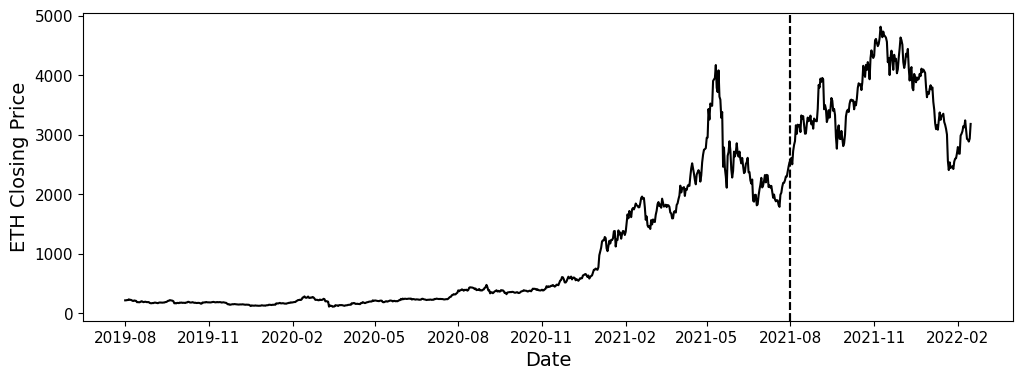

In [ ]:
plot_train_test_sep(df, "ETH")

## Data Prep Functions

Lag the selected features in the whole dataset by the same lag amount that is given as an input

In [ ]:
def lag_all_dataset(df, lag_var_list, max_lag_days):
    
    for x in lag_var_list:
        for i in range(max_lag_days):
            # shift as much as max_lag is defined
            df[x+'_'+str(i)] = df[x].shift(i)
    
    return df.drop(lag_var_list, axis=1)

Create binary classification target from daily returns. Can be 2 or 3 classes. The 2-class case involves only positive and negative return (1 and 0). The 3-class case involves positive, negative and no significant change, as defined by a threshold. We only use the 2-class version in this work, but the 3-class case has been used to experiment with.

In [ ]:
# transform target ----

def binary_target_classification(df, target, target_classif, num_classes):
        
    if num_classes==2:
        df['binary_temp'] = 0 #decrease
        df['binary_temp'].loc[df[target]>0] = 1 #increase
    if num_classes==3:
        df['binary_temp'] = 0 #decrease
        df['binary_temp'].loc[df[target]>=-0.005] = 1 #no significant change
        df['binary_temp'].loc[df[target]>0.005] = 2 #increase
    
    df[target_classif] = df['binary_temp'].values
    df = df.drop(['binary_temp'], axis=1)

    return df

Filter the dataset based on cryptocurrency name, text data source, minimum date and maximum date. Easy way to filter based on multiple criteria

In [ ]:
def data_filter(df, cur=[], source=[], date_min="", date_max=""):
    
    # filter fur currency
    if len(cur)>0:
        df = df.loc[df['cryptocurrency'].isin(cur)].reset_index(drop=True)
    
    # filter for source
    if len(source)>0:
        df = df.loc[df['source'].isin(source)].reset_index(drop=True)
    
    # filter for minimum date
    if date_min!="":
        df = df.loc[df['date']>=date_min].reset_index(drop=True)
    
    # filter for maximum date
    if date_max!="":
        df = df.loc[df['date']<=date_max].reset_index(drop=True)
    
    return df.reset_index(drop=True)

Prepare data in X and y format to easily input into the machine learning models. Also, only select selected features

In [ ]:
def model_data_pred(df, df_test, target_name, feat_list):

    # indep. vars.
    X = df[feat_list]
    y = df[target_name]
    
    # dependent var.
    X_test = df_test[feat_list]
    y_test = df_test[target_name]

    return X, y, X_test, y_test

Prepare test dataset in X and y format.

In [ ]:
def test_data_prep(df_test, target_name, feat_list):
    
    X_test = df_test[feat_list]
    y_test = df_test[target_name]

    return X_test, y_test

Discretize a continuous variable into as many classes as defined, based on the given thresholds and class names

In [ ]:
def discretize(df, thresh, class_names):
    
    return pd.cut(df,bins=[-100000,*thresh,100000],labels=class_names)

Create confusion matrix using real and predicted values. Works for as many classes as input

In [ ]:
def model_confusion(real_values, pred_values):
    
    size = len(real_values)
    # compute confusion matrix
    cf_matrix = confusion_matrix(real_values, pred_values,
                                labels=np.unique(real_values))
                                # labels=["positive", "negative", "neutral"])/size*100
    
    # create heatmap
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    
    ax.set_title('Return Prediction\n\n');
    ax.set_xlabel('pred')
    ax.set_ylabel('real');
    
    ax.xaxis.set_ticklabels(np.unique(real_values))
    ax.yaxis.set_ticklabels(np.unique(real_values))
    plt.show()
    
    return cf_matrix

Calculate accuracy score for regression models. The target is continuous, which is the value of return for the cryptocurrency. In this work, the trading strategy uses the direction of change, and therefore, accuracy is a more intuitive score than MSE or MAE, which is typical for regression models. This function discretizes and then calculates accuracy

In [ ]:
def regression_accuracy_score(df, pred_target, real_target, num_classes):
    
    df_binary = df.copy()
    df_binary = binary_target_classification(df_binary, pred_target, pred_target, num_classes)
    df_binary = binary_target_classification(df_binary, real_target, real_target, num_classes)

    return accuracy_score(df_binary[pred_target], df_binary[real_target])

## Variance Inflation Factor

Iteratively compute VIF and eliminate features. This is NOT used for the prediction models, but as an additinal analysis.

Separate by train-test

In [ ]:
train = data_filter(data, cur=[], source=[], date_min="2019-08-01", date_max="2021-07-31").dropna().reset_index(drop=True)
test = data_filter(data, cur=[], source=[], date_min="2021-08-01", date_max="2022-02-15").reset_index(drop=True)

Select features (eliminates dependent variable and other features to be removed from the features matrix)

In [ ]:
x_features = train.drop([target, target_c, *feat_remove], axis=1).columns
feat_set = x_features.copy()

Compute VIF and eliminate the feature with highest VIF, iteratively, until all VIF values are lower than the defined threshold.

In [ ]:
cur_vif = 1000 # arbitrary large number
vif_threshold = 2.5 # VIF threshold
feat_eliminated = list()

# iterative loop
while cur_vif > vif_threshold:
    
    X, y, X_test, y_test = model_data_pred(test, test, target_c, feat_set)
    sc = StandardScaler()
    sc.fit(X)
    X = pd.DataFrame(sc.transform(X), columns=feat_set)
    
    data_vif = pd.DataFrame()
    data_vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    data_vif['variable'] = X.columns
    data_vif = data_vif.sort_values('vif', ascending=False).reset_index(drop=True)

    # eliminate the one with highest VIF
    elim = data_vif['variable'][0]
    feat_eliminated.append(elim)
    print('eliminated feature is', elim, 'with VIF value', round(data_vif['vif'][0],2))

    cur_vif = data_vif['vif'][0]

    if cur_vif > vif_threshold:
        feat_set = np.setdiff1d(feat_set, elim)

eliminated feature is momentum_ao_2 with VIF value 63.56
eliminated feature is volume_sma_em_2 with VIF value 21.13
eliminated feature is volume_nvi_0 with VIF value 20.37
eliminated feature is trend_stc_2 with VIF value 17.12
eliminated feature is trend_kst_diff_2 with VIF value 16.25
eliminated feature is trend_adx_neg_2 with VIF value 10.09
eliminated feature is trend_mass_index_2 with VIF value 9.4
eliminated feature is momentum_stoch_rsi_0 with VIF value 8.62
eliminated feature is trend_aroon_down_0 with VIF value 8.43
eliminated feature is others_dr_2 with VIF value 7.9
eliminated feature is count_news_1 with VIF value 7.03
eliminated feature is volume_em_2 with VIF value 6.57
eliminated feature is trend_aroon_up_0 with VIF value 6.0
eliminated feature is weekday_Sunday with VIF value 5.45
eliminated feature is momentum_stoch_rsi_d_2 with VIF value 5.41
eliminated feature is volatility_bbw_0 with VIF value 4.57
eliminated feature is volume_em_0 with VIF value 4.54
eliminated feat

View remaining feature set

In [ ]:
print('Number of selected features is',len(feat_set))
print(feat_set)

Number of selected features is 43
['count_news_0' 'count_reddit_1' 'count_reddit_2' 'market_rate_treasury_0'
 'momentum_pvo_signal_2' 'rel_p_change_0' 'rel_p_change_1'
 'rel_p_change_2' 'return_daily_other_0' 'return_daily_other_1'
 'return_daily_other_2' 'return_sp500_0' 'return_sp500_1' 'return_sp500_2'
 'sentiment_news_0' 'sentiment_news_1' 'sentiment_news_2'
 'sentiment_reddit_0' 'sentiment_reddit_1' 'sentiment_reddit_2'
 'trend_adx_2' 'trend_dpo_0' 'trend_dpo_2' 'trend_psar_down_indicator_0'
 'trend_psar_down_indicator_1' 'trend_psar_down_indicator_2'
 'trend_psar_up_indicator_0' 'trend_psar_up_indicator_1'
 'trend_psar_up_indicator_2' 'volatility_bbhi_0' 'volatility_bbhi_1'
 'volatility_bbhi_2' 'volatility_bbli_0' 'volatility_bbli_1'
 'volatility_bbli_2' 'volatility_index_0' 'volatility_kchi_2'
 'volume_cmf_2' 'weekday_Friday' 'weekday_Monday' 'weekday_Saturday'
 'weekday_Thursday' 'weekday_Tuesday']


Saved the BTC features at VIF_threshold=5

In [ ]:
# 46 features
feat_set_btc = ['Volume_0' ,'Volume_1' ,'Volume_2' ,'avg_block_size_ma7_2' ,'count_reddit',
 'est_transac_volume_0' ,'est_transac_volume_2' ,'inf_rate_breakeven_2',
 'market_rate_treasury_0' ,'n_transac_0' ,'n_transac_2',
 'parkinson_volatility_0' ,'parkinson_volatility_1',
 'parkinson_volatility_2' ,'return_daily_2' ,'return_daily_other_0',
 'return_daily_other_1' ,'return_daily_other_2' ,'return_sp500_0',
 'return_sp500_1' ,'return_sp500_2' ,'sentiment_news' ,'sentiment_reddit',
 'sentiment_twitter' ,'transac_per_block_0' ,'trend_adx' ,'trend_aroon_down',
 'trend_dpo' ,'trend_mass_index' ,'trend_psar_down_indicator',
 'trend_psar_up_indicator' ,'trend_stc' ,'volatility_bbhi' ,'volatility_bbli',
 'volatility_bbw' ,'volatility_index_0' ,'volatility_kchi' ,'volatility_kcli',
 'volume_cmf' ,'volume_em' ,'weekday_Friday' ,'weekday_Monday',
 'weekday_Saturday' ,'weekday_Sunday' ,'weekday_Thursday' ,'weekday_Tuesday']

Saved the BTC features at VIF_threshold=2.5

In [ ]:
# 34 features
feat_set_btc_lower = ['count_reddit' ,'est_transac_volume_2' ,'market_rate_treasury_0',
 'n_transac_0' ,'n_transac_2' ,'parkinson_volatility_0',
 'parkinson_volatility_1' ,'parkinson_volatility_2' ,'return_daily_other_0',
 'return_daily_other_1' ,'return_daily_other_2' ,'return_sp500_0',
 'return_sp500_1' ,'return_sp500_2' ,'sentiment_news' ,'sentiment_reddit',
 'sentiment_twitter' ,'transac_per_block_0' ,'trend_adx' ,'trend_aroon_down',
 'trend_dpo' ,'trend_mass_index' ,'trend_psar_down_indicator',
 'trend_psar_up_indicator' ,'volatility_bbhi' ,'volatility_bbli',
 'volatility_bbw' ,'volatility_kchi' ,'volatility_kcli' ,'weekday_Friday',
 'weekday_Monday' ,'weekday_Sunday' ,'weekday_Thursday' ,'weekday_Tuesday']

Saved the ETH features at VIF_threshold=5

In [ ]:
# 42 features
feat_set_eth = ['count_news' ,'count_reddit' ,'count_twitter' ,'currency_volatility_2',
 'inf_rate_breakeven_0' ,'market_rate_treasury_2' ,'parkinson_volatility_1',
 'parkinson_volatility_2' ,'rel_p_change_0' ,'return_daily_2',
 'return_daily_other_0' ,'return_daily_other_1' ,'return_daily_other_2',
 'return_sp500_0' ,'return_sp500_1' ,'return_sp500_2' ,'sentiment_news',
 'sentiment_reddit' ,'sentiment_twitter' ,'trend_dpo' ,'trend_mass_index',
 'trend_psar_down_indicator' ,'trend_psar_up_indicator' ,'trend_stc',
 'volatility_bbhi' ,'volatility_bbli' ,'volatility_bbw' ,'volatility_index_0',
 'volatility_kchi' ,'volatility_kcli' ,'volume_cmf' ,'volume_em' ,'volume_mfi',
 'volume_other_0' ,'volume_other_1' ,'volume_other_2' ,'weekday_Friday',
 'weekday_Monday' ,'weekday_Saturday' ,'weekday_Sunday' ,'weekday_Thursday',
 'weekday_Tuesday']

Saved the ETH features at VIF_threshold=2.5

In [ ]:
# 32 features
feat_set_eth_lower = ['count_reddit' ,'currency_volatility_2' ,'inf_rate_breakeven_0',
 'market_rate_treasury_2' ,'parkinson_volatility_1',
 'parkinson_volatility_2' ,'rel_p_change_0' ,'return_daily_2',
 'return_daily_other_0' ,'return_daily_other_1' ,'return_sp500_0',
 'return_sp500_1' ,'return_sp500_2' ,'sentiment_news' ,'sentiment_reddit',
 'sentiment_twitter' ,'trend_dpo' ,'trend_mass_index',
 'trend_psar_down_indicator' ,'trend_psar_up_indicator' ,'volatility_bbhi',
 'volatility_bbli' ,'volatility_kchi' ,'volatility_kcli' ,'volume_mfi',
 'volume_other_2' ,'weekday_Friday' ,'weekday_Monday' ,'weekday_Saturday',
 'weekday_Sunday' ,'weekday_Thursday' ,'weekday_Tuesday']

Old version ----

In [ ]:
# for btc
feat_set = ['Volume_0', 'Volume_1', 'Volume_2', 'avg_block_size_ma7_2', 'count_news_0',
 'count_news_1', 'count_news_2', 'count_reddit_0', 'count_reddit_1',
 'count_reddit_2', 'est_transac_volume_0', 'est_transac_volume_2',
 'miners_rev_0', 'momentum_ao_2', 'momentum_pvo_2', 'momentum_pvo_hist_2',
 'momentum_stoch_rsi_d_2', 'n_transac_2', 'others_dlr_0', 'others_dr_2',
 'rel_p_change_0', 'rel_p_change_1', 'rel_p_change_2', 'return_daily_other_0',
 'return_daily_other_1', 'return_daily_other_2', 'return_sp500_0',
 'return_sp500_1', 'return_sp500_2', 'sentiment_news_0', 'sentiment_news_1',
 'sentiment_news_2', 'sentiment_reddit_0', 'sentiment_reddit_1',
 'sentiment_reddit_2', 'sentiment_twitter_0', 'sentiment_twitter_1',
 'transac_per_block_2', 'trend_adx_2', 'trend_adx_pos_2',
 'trend_aroon_down_0', 'trend_aroon_up_0', 'trend_dpo_0', 'trend_dpo_1',
 'trend_dpo_2', 'trend_kst_diff_2', 'trend_mass_index_2',
 'trend_psar_down_indicator_0', 'trend_psar_down_indicator_1',
 'trend_psar_down_indicator_2', 'trend_psar_up_indicator_0',
 'trend_psar_up_indicator_1', 'trend_psar_up_indicator_2', 'trend_stc_2',
 'volatility_bbhi_0', 'volatility_bbhi_1', 'volatility_bbhi_2',
 'volatility_bbli_0', 'volatility_bbli_1', 'volatility_bbli_2',
 'volatility_bbw_0', 'volatility_index_0', 'volatility_kchi_0',
 'volatility_kchi_1', 'volatility_kchi_2', 'volatility_kcli_0',
 'volatility_kcli_1', 'volatility_kcli_2', 'volume_cmf_2', 'volume_em_0',
 'volume_em_1', 'volume_em_2', 'volume_mfi_2', 'volume_vpt_2',
 'weekday_Friday', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
 'weekday_Thursday', 'weekday_Tuesday']

In [ ]:
len(feat_set)

73

In [ ]:
# for eth
feat_set = ['count_news_0', 'count_news_1', 'count_reddit_1', 'count_reddit_2',
 'market_rate_treasury_0', 'momentum_ao_2', 'momentum_pvo_signal_2',
 'momentum_stoch_rsi_0', 'momentum_stoch_rsi_d_2', 'others_dr_2',
 'rel_p_change_0', 'rel_p_change_1', 'rel_p_change_2', 'return_daily_other_0',
 'return_daily_other_1', 'return_daily_other_2', 'return_sp500_0',
 'return_sp500_1', 'return_sp500_2', 'sentiment_news_0', 'sentiment_news_1',
 'sentiment_news_2', 'sentiment_reddit_0', 'sentiment_reddit_1',
 'sentiment_reddit_2', 'trend_adx_2', 'trend_adx_neg_2', 'trend_aroon_down_0',
 'trend_aroon_down_2', 'trend_aroon_up_0', 'trend_dpo_0', 'trend_dpo_1',
 'trend_dpo_2', 'trend_kst_diff_2', 'trend_mass_index_2',
 'trend_psar_down_indicator_0', 'trend_psar_down_indicator_1',
 'trend_psar_down_indicator_2', 'trend_psar_up_indicator_0',
 'trend_psar_up_indicator_1', 'trend_psar_up_indicator_2', 'trend_stc_2',
 'volatility_bbhi_0', 'volatility_bbhi_1', 'volatility_bbhi_2',
 'volatility_bbli_0', 'volatility_bbli_1', 'volatility_bbli_2',
 'volatility_bbw_0', 'volatility_index_0', 'volatility_kchi_0',
 'volatility_kchi_1', 'volatility_kchi_2', 'volatility_kcli_0',
 'volatility_kcli_1', 'volatility_kcli_2', 'volume_cmf_2', 'volume_em_0',
 'volume_em_1', 'volume_em_2', 'volume_mfi_2', 'volume_nvi_0',
 'volume_other_0', 'volume_other_1', 'volume_other_2', 'volume_sma_em_2',
 'volume_vpt_2', 'weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
 'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday']

## Granger Causality Analysis

--- Old version

For computing granger causality as an additional analysis for the ability of sentiment features to predict returns. We do NOT use this in the final work..

In [ ]:
featlist_granger = train.columns
sentimentlist_granger = [*[feat for feat in featlist_granger if "sentiment" in feat], *[feat for feat in featlist_granger if "count" in feat]]
sentimentlist_granger

['sentiment_overall',
 'sentiment_news',
 'sentiment_twitter',
 'sentiment_reddit',
 'count_news',
 'count_reddit',
 'count_twitter',
 'count_total']

In [ ]:
def granger_sentiment_target(df, target, sent_feat, maxlag, test='ssr_chi2test'):
    granger_matrix = grangers_causation_matrix(df, variables=[target, sent_feat], maxlag=maxlag)
    sentiment_target_causality = granger_matrix[sent_feat+'_x'][target+'_y']
    return sentiment_target_causality

In [ ]:
def grangers_causation_matrix(data, variables, maxlag, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
for f in [*sentimentlist_granger, target]:
  print(f)
  X = train[f].values
  result = adfuller(X)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

sentiment_overall
ADF Statistic: -4.425830
p-value: 0.000267
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
sentiment_news
ADF Statistic: -24.565393
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
sentiment_twitter
ADF Statistic: -8.370545
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
sentiment_reddit
ADF Statistic: -4.697944
p-value: 0.000085
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
count_news
ADF Statistic: -1.755616
p-value: 0.402709
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
count_reddit
ADF Statistic: -3.621154
p-value: 0.005369
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
count_twitter
ADF Statistic: -0.456975
p-value: 0.900143
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
count_total
ADF Statistic: -0.184822
p-value: 0.940307
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
return_tmr
ADF Statistic: -12.466766
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.

In [ ]:
train_stationary = train.copy()
(df2 - df2.shift()).fillna(0)

In [ ]:
sent_granger = granger_sentiment_target(data, target, 'sentiment_overall', maxlag=3)
sent_granger

0.1886

In [ ]:
grangers_causation_matrix(data, [*sentimentlist_granger, target], 14)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints

,sentiment_overall_x,sentiment_news_x,sentiment_twitter_x,sentiment_reddit_x,count_news_x,count_reddit_x,count_twitter_x,count_total_x,return_tmr_x
sentiment_overall_y,1.0000,0.0013,0.1971,0.0014,0.0003,0.5228,0.0010,0.0002,0.0000
sentiment_news_y,0.3804,1.0000,0.1804,0.6527,0.0462,0.2742,0.0007,0.0005,0.0000
sentiment_twitter_y,0.0021,0.1873,1.0000,0.0000,0.0013,0.6992,0.0006,0.0001,0.0000
sentiment_reddit_y,0.0202,0.0048,0.0053,1.0000,0.0087,0.3826,0.0000,0.0000,0.0000
count_news_y,0.0005,0.0061,0.0011,0.0183,1.0000,0.2307,0.0000,0.0000,0.3674
count_reddit_y,0.2236,0.4181,0.1459,0.6156,0.3460,1.0000,0.0687,0.0724,0.0761
count_twitter_y,0.4551,0.2741,0.6334,0.0450,0.0032,0.2398,1.0000,0.0029,0.0005
count_total_y,0.0034,0.0074,0.1649,0.0087,0.0000,0.0000,0.0000,1.0000,0.0023
return_tmr_y,0.0804,0.2400,0.2662,0.0696,0.3842,0.1233,0.0428,0.5059,1.0000


## Build Classification Models

Not used anymore, since models are built directly through Bayesian hyperparameter optimization.

Use this if you do not want to compute hyperparameter tuning but just fit the models

In [ ]:
def get_clf_models(X, y):
    models = dict()
    # # tree
    # model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth = 9, min_samples_leaf=12,
    #                    max_features='auto', max_leaf_nodes=20, random_state=5)
    # model.fit(X,y)
    # models['tree'] = model
    # # lr
    # model = LogisticRegression(C=0.1, penalty='l2', solver='saga')
    # model.fit(X,y)
    # models['lr'] = model
    # # per
    # model = Perceptron(max_iter=5000, eta0=0.1, random_state=1)
    # model.fit(X,y)
    # models['per'] = model
    # # rf
    # model = RandomForestClassifier(bootstrap=True, max_depth=3, max_features='auto',
    #                         min_samples_leaf=12, min_samples_split=5, n_estimators=500, random_state=123)
    # model.fit(X,y)
    # models['rf'] = model
    # # svm
    # model = SVC(C=1, kernel='rbf', gamma='auto', probability=True, random_state=10)
    # model.fit(X,y)
    # models['svm'] = model
    # # gbm
    # model = GradientBoostingClassifier(max_features='sqrt', max_depth=3, min_samples_leaf=12,
    #                             learning_rate=0.01, subsample=0.6, n_estimators=100, random_state=1)
    # model.fit(X,y)
    # models['gbm'] = model
    # # mlp
    # model = MLPClassifier(solver='lbfgs', alpha=0.001, hidden_layer_sizes=(10, 5),
    #                       random_state=1, activation='relu', learning_rate='constant')
    # model.fit(X,y)
    # models['mlp'] = model
    # # knn
    # model = KNeighborsClassifier(leaf_size=40, n_neighbors=20, p=2, algorithm='ball_tree', weights='distance')
    # model.fit(X,y)
    # models['knn'] = model
    # # gnb
    # model = GaussianNB(priors = None, var_smoothing = 1e-7)
    # model.fit(X,y)
    # models['gnb'] = model
    # # ada
    # model = AdaBoostClassifier(n_estimators=80, learning_rate=0.5, random_state=100)
    # model.fit(X,y)
    # models['ada'] = model
    # # ens_vote_all
    # model = VotingClassifier(
    #     estimators=[('lr', models['lr']), ('svm', models['svm']), 
    #                 ('gbm', models['gbm']), ('mlp', models['mlp']),
    #                 ('rf', models['rf']), ('tree', models['tree']), 
    #                 ('per', models['per']), ('knn', models['knn']),
    #                 ('gnb', models['gnb']), ('ada', models['ada'])], voting='hard')
    # model.fit(X,y)
    # models['ens_vote_all'] = model
    # # # ens_vote_3
    # # model = VotingClassifier(
    # #     estimators=[('lr', models['lr']), ('ada', models['ada']), 
    # #                 ('svm', models['svm'])], voting='hard')
    # # model.fit(X,y)
    # # models['ens_vote_3'] = model
    # # ens_stack_all
    # model = StackingClassifier(
    #     estimators=[('lr', models['lr']), ('svm', models['svm']), 
    #                 ('gbm', models['gbm']), ('mlp', models['mlp']),
    #                 ('rf', models['rf']), ('tree', models['tree']), 
    #                 ('per', models['per']), ('gnb', models['gnb'])], 
    #     final_estimator=LogisticRegression(C=0.1, solver='saga'))
    # model.fit(X,y)
    # models['ens_stack_all'] = model
    return models

## Build Regression Models

Same as classification. Not used anymore ---

In [ ]:
def get_reg_models(X, y):
    models = dict()
    # tree
    model = DecisionTreeRegressor(max_depth=9, splitter='best', min_samples_leaf=10,
                                  max_leaf_nodes=20, max_features='sqrt')
    model.fit(X,y)
    models['tree'] = model
    # ridge
    model = Ridge(copy_X=True, fit_intercept=True, alpha=1, random_state=100)
    model.fit(X,y)
    models['ridge'] = model
    # # rf
    # model = RandomForestRegressor(criterion='absolute_error', max_depth=7, max_features='sqrt',
    #                          min_samples_leaf=10, n_estimators=100, random_state=33)
    # model.fit(X,y)
    # models['rf'] = model
    # # svm
    # model = SVR(C=0.1, kernel='linear', gamma='scale')
    # model.fit(X,y)
    # models['svm'] = model
    # # gbm
    # model = GradientBoostingRegressor(max_features='sqrt', learning_rate=0.1, max_depth=5,
    #                          random_state=1, min_samples_leaf=8, subsample=0.8, n_estimators=300)
    # model.fit(X,y)
    # models['gbm'] = model
    # # mlp
    # model = MLPRegressor(solver='lbfgs', alpha=0.0001, hidden_layer_sizes=(10, 5), random_state=100,
    #              learning_rate='constant', learning_rate_init=0.01, activation='relu')
    # model.fit(X,y)
    # models['mlp'] = model
    # # knn
    # model = KNeighborsRegressor(leaf_size=60, n_neighbors=50, p=2, algorithm='ball_tree', weights='distance')
    # model.fit(X,y)
    # models['knn'] = model
    # # ada
    # model = AdaBoostRegressor(n_estimators=30, learning_rate=1, random_state=1)
    # model.fit(X,y)
    # models['ada'] = model
    # # ens_vote_all
    # model = VotingRegressor(
    #     estimators=[('lr', models['lr']), ('svm', models['svm']), 
    #                 ('gbm', models['gbm']), ('mlp', models['mlp']),
    #                 ('rf', models['rf']), ('tree', models['tree']), 
    #                 ('knn', models['knn']), ('ada', models['ada'])], weights=None)
    # model.fit(X,y)
    # models['ens_vote_all'] = model
    # # # ens_stack_3
    # # model = StackingRegressor(
    # #     estimators=[('mlp', models['mlp']), ('ada', models['ada']), 
    # #                 ('gbm', models['gbm'])], final_estimator=LinearRegression())
    # # model.fit(X,y)
    # # models['ens_vote_3'] = model
    # # ens_stack_all
    # model = StackingRegressor(
    #     estimators=[('lr', models['lr']), ('svm', models['svm']), 
    #                 ('gbm', models['gbm']), ('mlp', models['mlp']),
    #                 ('rf', models['rf']), ('tree', models['tree'])], 
    #     final_estimator=LinearRegression())
    # model.fit(X,y)
    # models['ens_stack_all'] = model
    return models

## Model Functions

All functions that are used for building the models, hyperparameter tuning, implementing the trading simulation to the model building, and so on.

Define a custom scoring function to perform cross-validated hyperparameter tuning. For both classification and regression models, the scoring metric is balanced accuracy score.

In [ ]:
def custom_scoring_function(m, X, y):
    y_pred = m.predict(X)
    y_pred = discretize(y_pred, thresh=[0.0], class_names=[0,1])
    y_clf = discretize(y, thresh=[0.0], class_names=[0,1])
    score = balanced_accuracy_score(y_pred, y_clf)
    return score

Fit all models for a given feature set, cryptocurrency, and classification/regression.

In [ ]:
def fit_all_models(feat_set_now, set_name, n_iter):
    start = time.time()
    X, y, X_test, y_test = model_data_pred(train, test, target_var, feat_set_now)
    # X, y, X_test, y_test = model_data_pred(train, test, target_var, np.setdiff1d(feat_set_now, [feat for feat in feat_set_now if "weekday" in feat_set_now]))
    sc = StandardScaler()
    sc.fit(X)
    X = sc.transform(X)
    X_test = sc.transform(X_test)

    # get the models to evaluate
    # if is_regression:
    #     models = get_reg_models(X, y)
    # else:
    #     models = get_clf_models(X, y)
    # evaluate the models and store results
    train_trade = train.copy()
    test_trade = test.copy()
    input_amount = 1000
    transaction_cost_ratio = 0.002
    results, names, acc_test = list(), list(), list()
    test_transactions, test_pred, params_opt = dict(), dict(), dict()
    out_test = pd.DataFrame()
    models = dict()
    
    # adjust the CV parameters, hyperparameters, model, scoring function based on clf/reg
    if is_regression:
      name = 'reg'
      score_metric = custom_scoring_function
      params = param_grid_reg
      cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
      model_list = model_list_reg
    else:
      name = 'clf'
      score_metric = 'balanced_accuracy'
      params = param_grid_clf
      cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
      model_list = model_list_clf

    # models list except for ensembles
    single_model_names = np.setdiff1d(model_list, ['ens_vote', 'ens_stack'])

    # for each model in the list
    for name in model_list:
        
        # if not ensemble
        if name in single_model_names:
          # perform bayesian cv search
          opt = BayesSearchCV(params['model'][name][0], params[name], cv = cv, n_iter=n_iter, 
                      scoring=score_metric, verbose=1, n_jobs=-1, random_state=123, refit=True)
          opt.fit(X, y)

          # best score
          scores = opt.score(X, y) # balanced accuracy on train dataset
          results.append(scores)
          models[name] = opt
          params_opt[name] = opt.best_params_
        # if ensemble
        else:
          # ensemble voting for clf
          if (not is_regression) & (name=='ens_vote'):
            models[name] = VotingClassifier(estimators=
                    [(m, param_grid_clf['model'][m][0].set_params(**params_opt[m])) for m in single_model_names], 
                      voting='hard')
            models[name].fit(X,y)
            train_trade['y_pred'] = models[name].predict(X)
            results.append(accuracy_score(train_trade['y_pred'], y))
          # ensemble stacking for clf
          elif (not is_regression) & (name=='ens_stack'):
            models[name] = StackingClassifier(
                estimators = [(m, param_grid_clf['model'][m][0].set_params(**params_opt[m])) for m in single_model_names], 
                final_estimator=DecisionTreeClassifier(max_depth=2))
            models[name].fit(X,y)
            train_trade['y_pred'] = models[name].predict(X)
            results.append(accuracy_score(train_trade['y_pred'], y))
          # ensemble voting for reg
          elif (is_regression) & (name=='ens_vote'):
            models[name] = VotingRegressor(estimators=
                    [(m, param_grid_reg['model'][m][0].set_params(**params_opt[m])) for m in single_model_names], 
                      weights=None)
            models[name].fit(X,y)
            train_trade['y_pred'] = models[name].predict(X)
            results.append(regression_accuracy_score(train_trade, 'y_pred', target_var, 2))
          # ensemble stacking for reg
          elif (is_regression) & (name=='ens_stack'):
            models[name] = StackingRegressor(
                estimators = [(m, param_grid_reg['model'][m][0].set_params(**params_opt[m])) for m in single_model_names], 
                final_estimator=LinearRegression())
            models[name].fit(X,y)
            train_trade['y_pred'] = models[name].predict(X)
            results.append(regression_accuracy_score(train_trade, 'y_pred', target_var, 2))
          params_opt[name] = name

        names.append(name)
        test_pred_temp = models[name].predict(X_test)
        test_pred[name] = test_pred_temp
        test_trade['y_pred'] = test_pred_temp
        # test accuracy metric calculate
        if is_regression:
            acc_test.append(regression_accuracy_score(test_trade, 'y_pred', target_var, 2))
        else:
            acc_test.append(accuracy_score(test_trade['y_pred'], y_test))
        
        # create output table for each model using trading simulation
        out_test_temp, transactions_temp = shift_trade_window(input_amount, test_trade, 'y_pred', target_var, 10, 60, 
                                                      transaction_cost_ratio, name, set_name)

        out_test = out_test.append(out_test_temp)
        test_transactions[name] = transactions_temp
        print(regression_accuracy_score(test_trade, 'y_pred', target_var, 2))

    end = time.time()
    print("elapsed time is " + str(round((end-start)/60)) + " minutes")
    return (models, results, names, params_opt, acc_test, test_pred, test_transactions, out_test)

Evaluate models with different metrics. Not used anymore ----

In [ ]:
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    if is_regression:
        score_metric = 'neg_mean_squared_error'
        cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    else:
        score_metric = 'accuracy'
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring=score_metric, cv=cv, n_jobs=-1)
    return scores

Select the required feature set based on the definition. Can be all, only sentiment, no sentiment, or VIF-selected.

In [ ]:
def feature_subset(include='all'):
  
    all_feat = train.drop([target, target_c, *feat_remove], axis=1).columns.tolist()
    sentiment_feature_names = [*[feat for feat in all_feat if "sentiment" in feat], *[feat for feat in all_feat if "count" in feat]]
        
    if include=='all':
        return train.drop([target, target_c, *feat_remove], axis=1).columns.tolist()
    elif include=='no_sentiment':
        return train.drop([target, target_c, *feat_remove, *sentiment_feature_names], axis=1).columns.tolist()
    elif include=='only_sentiment':
        return sentiment_feature_names
    elif include=='vif':
        return feat_set_btc_lower if current_currency=='BTC' else feat_set_eth_lower
    else:
        return feat_set

Repeats fit_all_models() function for all defined feature sets for comparison of with and without sentiment.

In [ ]:
def model_fit_feature_subsets(n_iter):
    
    # chosen feature sets
    feature_choice_list = ['all', 'no_sentiment']#, 'only_sentiment', 'vif']
    output_all = pd.DataFrame()
    models_all, test_predictions, transactions_summary = dict(), dict(), dict()
    out_table_test = pd.DataFrame()

    # repeat for each set
    for f_set in feature_choice_list:
        print("Feature subset:", f_set)
        input_features = feature_subset(include=f_set)
        (models, results, names, params_opt, acc_test, test_pred, test_tran, output_test) = fit_all_models(input_features, f_set, n_iter)
        output = pd.DataFrame({"train accuracy": results, #[cv_error.mean() for cv_error in results], 
                      "test accuracy": acc_test,
                      "parameters": [str(prm) for prm in params_opt]})
        out_table_test = out_table_test.append(output_test)
        models_all[f_set] = models
        test_predictions[f_set] = test_pred
        transactions_summary[f_set] = test_tran
        output_all = output_all.append(output).reset_index(drop=True)

    out_table_test.insert(2, 'train accuracy', np.round(output_all['train accuracy'].values,3))
    out_table_test.insert(3, 'test accuracy', np.round(output_all['test accuracy'].values,3))
    out_table_test['parameters'] = output_all['parameters'].values
    if is_regression:
        out_table_test.insert(0, 'model type', 'regression')
    else:
        out_table_test.insert(0, 'model type', 'classification')
    
    # conclude output table
    out_table_test.insert(0, 'cryptocurrency', current_currency)
    out_table_test = out_table_test.reset_index(drop=True)

    return out_table_test, models_all, test_predictions, transactions_summary

## Fit & Evaluate Models

Uncomment the models that you would like to train. Hyperparameter tuning is performed to fit the optimal model. All of the following models are used for this work.

In [ ]:
model_list_clf = [
              # 'lr',
              'rf',
              # 'svm',
              # 'per',
              # 'gbm',
              # 'mlp',
              # 'knn',
              # 'ada',
              # 'tree',
              'xgb',
              'lgbm',
              # 'ens_vote',
              # 'ens_stack'
              ]

model_list_reg = [
              # 'ridge',
              'rf',
              # 'svm',
              'cat',
              # 'gbm',
              # 'mlp',
              # 'sgd',
              # 'ada',
              # 'tree',
              'xgb',
              'lgbm',
              # 'ens_vote',
              # 'ens_stack'
]

The 'main' part where everything is run. Select a currency list, model type list, and fit all models for all feature sets.

In [ ]:
currencies = ['BTC'] # BTC, ETH
model_types = [True, False] # is_regression boolean

output_all_models = pd.DataFrame()
OPT_ITER = 40 # Bayesian optimization iteration number
models_cryptos, models_all = dict(), dict()

# repeat for all cryptos
for current_currency in currencies:

  print(current_currency)

  data, feat_remove = get_data()
  train = data_filter(data, cur=[], source=[], date_min="2019-08-01", date_max="2021-07-31").dropna().reset_index(drop=True)
  test = data_filter(data, cur=[], source=[], date_min="2021-08-01", date_max="2022-02-15").reset_index(drop=True)
  
  # repeat for each clf/reg
  for is_regression in model_types:

    if is_regression:
        target_var = target
        name = 'reg'
    else:
        target_var = target_c
        name = 'clf'

    print(target_var)

    output, models_all[name], test_predictions, test_transactions = model_fit_feature_subsets(n_iter=OPT_ITER)
    models_cryptos[current_currency] = models_all

    output_all_models = output_all_models.append(output)

In [ ]:
models_cryptos['BTC']['reg']['all']['tree'].best_params_
# no_sentiment all

OrderedDict([('max_features', 'sqrt'),
             ('min_samples_leaf', 7),
             ('splitter', 'best')])

In [ ]:
# viet the output table
output_all_models.sort_values('gain scaled random', ascending=False)

,cryptocurrency,model type,model,feature set,train accuracy,test accuracy,input amount,trade period_days,number of trade periods,output amount random,output amount ideal,output amount buy and hold,output amount predicted,gain scaled hold,t-test gain scaled hold,gain scaled random,t-test gain scaled random,output amount cost,num transactions,parameters
3,BTC,classification,lgbm,no_sentiment,0.910,0.548,1000,60,14,805.18 (216.63),2011.8 (404.82),1017.42 (291.39),1077.57 (66.69),0.136 (0.273),0.48,0.421 (0.309),0.00056,29.16 (10.08),14 (4),lgbm
0,BTC,classification,xgb,all,0.724,0.528,1000,60,14,805.18 (216.63),2011.8 (404.82),1017.42 (291.39),1020.95 (47.66),0.105 (0.361),0.97,0.376 (0.409),0.00340,26.89 (13.62),13 (6),xgb
1,BTC,classification,lgbm,all,0.918,0.523,1000,60,14,805.18 (216.63),2011.8 (404.82),1017.42 (291.39),1022.64 (54.28),0.083 (0.278),0.95,0.353 (0.312),0.00330,24.32 (6.46),12 (3),lgbm
3,BTC,regression,cat,no_sentiment,0.732,0.492,1000,60,14,805.18 (216.63),2011.8 (404.82),1017.42 (291.39),972.81 (53.8),0.046 (0.326),0.60,0.309 (0.38),0.01700,18.25 (15.32),9 (8),cat
5,BTC,regression,lgbm,no_sentiment,0.852,0.513,1000,60,14,805.18 (216.63),2011.8 (404.82),1017.42 (291.39),975.27 (64.68),0.034 (0.274),0.62,0.298 (0.324),0.01600,32.56 (9.9),16 (5),lgbm
2,BTC,regression,lgbm,all,0.852,0.528,1000,60,14,805.18 (216.63),2011.8 (404.82),1017.42 (291.39),976.01 (30.91),0.04 (0.285),0.62,0.298 (0.321),0.01400,34.68 (10.02),17 (5),lgbm
0,BTC,regression,cat,all,0.714,0.492,1000,60,14,805.18 (216.63),2011.8 (404.82),1017.42 (291.39),946.97 (66.16),0.024 (0.339),0.41,0.282 (0.397),0.03900,20.15 (15.83),11 (9),cat
1,BTC,regression,xgb,all,0.523,0.508,1000,60,14,805.18 (216.63),2011.8 (404.82),1017.42 (291.39),1017.42 (291.39),-0.0 (0.0),1.00,0.264 (0.139),0.04600,4.04 (0.58),1 (0),xgb
4,BTC,regression,xgb,no_sentiment,0.523,0.508,1000,60,14,805.18 (216.63),2011.8 (404.82),1017.42 (291.39),1017.42 (291.39),-0.0 (0.0),1.00,0.264 (0.139),0.04600,4.04 (0.58),1 (0),xgb
2,BTC,classification,xgb,no_sentiment,0.717,0.472,1000,60,14,805.18 (216.63),2011.8 (404.82),1017.42 (291.39),906.82 (151.47),-0.042 (0.278),0.24,0.187 (0.294),0.18000,47.1 (5.9),25 (5),xgb


A way to view the hyperparameters

In [ ]:
for m in model_list_clf:
  pprint(m + '--------------------')
  for cc in ['BTC', 'ETH']:
    for f in ['all', 'no_sentiment']:
      pprint(cc + '-clf-' + f + '-' + m)
      pprint(models_cryptos[cc]['clf'][f][m].best_params_)
for m in model_list_reg:
  pprint(m + '--------------------')
  for cc in ['BTC', 'ETH']:
    for f in ['all', 'no_sentiment']:
      pprint(cc + '-reg-' + f + '-' + m)
      pprint(models_cryptos[cc]['reg'][f][m].best_params_)

'gbm--------------------'
'BTC-clf-all-gbm'
OrderedDict([('learning_rate', 0.49950019902325143),
             ('max_depth', 2),
             ('max_features', 'auto'),
             ('min_samples_split', 5),
             ('n_estimators', 99),
             ('random_state', 5),
             ('subsample', 0.7312796122542209)])
'BTC-clf-no_sentiment-gbm'
OrderedDict([('learning_rate', 0.48557743114730983),
             ('max_depth', 3),
             ('max_features', 'log2'),
             ('min_samples_split', 2),
             ('n_estimators', 69),
             ('random_state', 2),
             ('subsample', 0.7228534842462759)])
'ETH-clf-all-gbm'
OrderedDict([('learning_rate', 0.49950019902325143),
             ('max_depth', 2),
             ('max_features', 'auto'),
             ('min_samples_split', 5),
             ('n_estimators', 99),
             ('random_state', 5),
             ('subsample', 0.7312796122542209)])
'ETH-clf-no_sentiment-gbm'
OrderedDict([('learning_rate', 0.48557743114

In [ ]:
# output_all_models.sort_values('gain scaled random', ascending=False)
output_all_models.sort_values(['model', 'gain scaled random'], ascending=False)

,cryptocurrency,model type,model,feature set,train accuracy,test accuracy,input amount,trade period_days,number of trade periods,output amount random,output amount ideal,output amount buy and hold,output amount predicted,gain scaled hold,t-test gain scaled hold,gain scaled random,t-test gain scaled random,output amount cost,num transactions,parameters
6,ETH,classification,xgb,no_sentiment,1.000,0.523,1000,60,14,900.23 (271.94),2494.01 (473.74),1056.41 (292.37),1100.14 (197.67),0.081 (0.169),0.66,0.286 (0.233),0.0420,49.67 (9.28),23 (4),xgb
6,BTC,regression,xgb,no_sentiment,0.770,0.508,1000,60,14,805.18 (216.63),2011.8 (404.82),1017.42 (291.39),1017.42 (291.39),-0.0 (0.0),1.00,0.264 (0.139),0.0460,4.04 (0.58),1 (0),xgb
2,BTC,regression,xgb,all,0.926,0.492,1000,60,14,805.18 (216.63),2011.8 (404.82),1017.42 (291.39),942.52 (133.55),-0.024 (0.193),0.41,0.229 (0.246),0.0650,40.3 (4.57),20 (3),xgb
2,ETH,regression,xgb,all,0.773,0.508,1000,60,14,900.23 (271.94),2494.01 (473.74),1056.41 (292.37),1056.41 (292.37),0.0 (0.0),1.00,0.189 (0.112),0.1700,4.12 (0.59),1 (0),xgb
6,ETH,regression,xgb,no_sentiment,0.773,0.508,1000,60,14,900.23 (271.94),2494.01 (473.74),1056.41 (292.37),1056.41 (292.37),0.0 (0.0),1.00,0.189 (0.112),0.1700,4.12 (0.59),1 (0),xgb
2,ETH,classification,xgb,all,1.000,0.508,1000,60,14,900.23 (271.94),2494.01 (473.74),1056.41 (292.37),988.25 (136.21),-0.015 (0.195),0.46,0.18 (0.288),0.3100,43.88 (3.54),21 (2),xgb
6,BTC,classification,xgb,no_sentiment,1.000,0.528,1000,60,14,805.18 (216.63),2011.8 (404.82),1017.42 (291.39),917.12 (146.89),-0.053 (0.183),0.28,0.18 (0.167),0.1400,54.79 (8.61),28 (2),xgb
2,BTC,classification,xgb,all,0.992,0.533,1000,60,14,805.18 (216.63),2011.8 (404.82),1017.42 (291.39),882.84 (62.62),-0.064 (0.245),0.13,0.168 (0.275),0.2300,56.93 (13.1),29 (6),xgb
1,BTC,classification,tree,all,0.543,0.508,1000,60,14,805.18 (216.63),2011.8 (404.82),1017.42 (291.39),1017.42 (291.39),-0.0 (0.0),1.00,0.264 (0.139),0.0460,4.04 (0.58),1 (0),tree
1,ETH,regression,tree,all,0.749,0.508,1000,60,14,900.23 (271.94),2494.01 (473.74),1056.41 (292.37),982.43 (66.14),0.02 (0.343),0.39,0.224 (0.45),0.3100,15.55 (11.53),8 (6),tree


In [ ]:
output_all_models.to_excel('/drive/My Drive/Colab Notebooks/final output/alloutVIF_gereksiz.xlsx', sheet_name = 'New_sheet')

In [ ]:
# current_currency = 'BTC'
# data, feat_remove = get_data()

In [ ]:
# is_regression = False
# if is_regression:
#     target_var = target
# else:
#     target_var = target_c

# print(target_var)

In [ ]:
# train = data_filter(data, cur=[], source=[], date_min="2019-08-01", date_max="2021-07-31").dropna().reset_index(drop=True)
# test = data_filter(data, cur=[], source=[], date_min="2021-08-01", date_max="2022-02-15").reset_index(drop=True)

In [ ]:
test.groupby(target_c).size()/test.shape[0]

In [ ]:
# output, models_all, test_predictions, test_transactions = model_fit_feature_subsets()

Feature subset: all


In [ ]:
output.sort_values('gain scaled random', ascending=False)

[1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0
 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 1 1 1
 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 1
 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1
 1 1 0 1 0 0 0 0 0 1 1 1 1 1]


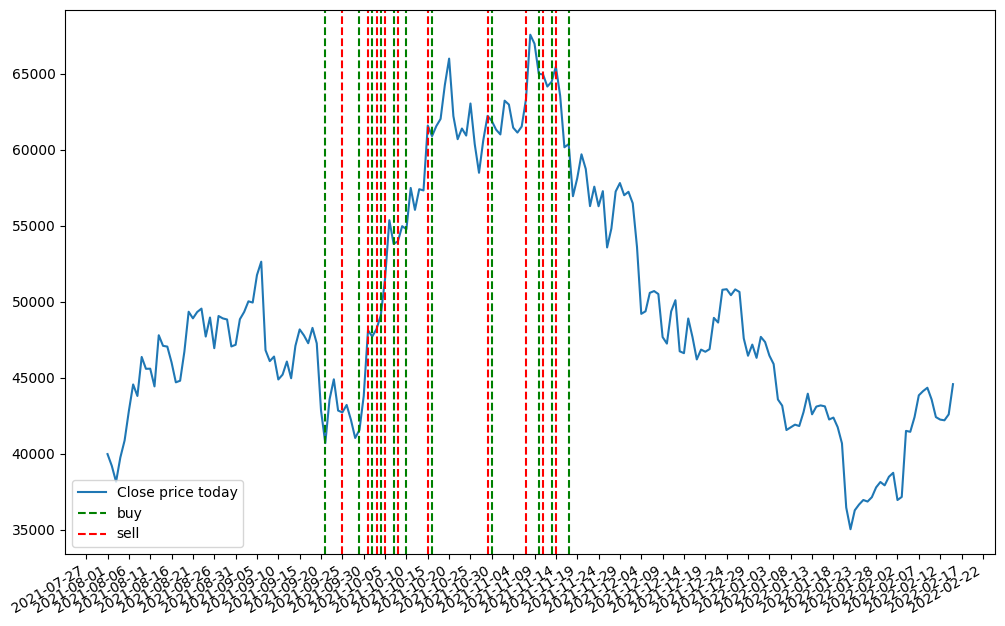

In [ ]:
feature_subset = 'no_sentiment'
model_choice = 'ada'
window_index = 5
print(test_predictions[feature_subset][model_choice])
plot_trade_simulation(test, test_transactions[feature_subset][model_choice]['window_'+str(window_index)], plot_all=True)

In [ ]:
test_transactions[feature_subset][model_choice]['window_'+str(window_index)]

,date,buy_sell,price,amount,date_dt
0,2021-08-11,buy,45593.636719,0.021889,2021-08-11
0,2021-08-12,sell,44428.289062,970.546699,2021-08-12
0,2021-08-14,buy,47096.945312,0.020566,2021-08-14
0,2021-08-20,sell,49339.175781,1012.690346,2021-08-20
0,2021-08-21,buy,48905.492188,0.020666,2021-08-21
0,2021-08-22,sell,49321.652344,1017.226665,2021-08-22
0,2021-08-23,buy,49546.148438,0.020490,2021-08-23
0,2021-08-26,sell,46942.218750,959.914456,2021-08-26
0,2021-08-28,buy,48902.402344,0.019590,2021-08-28
0,2021-08-29,sell,48829.832031,954.659834,2021-08-29


In [ ]:
output_all

,cryptocurrency,model,features,train_cv_accuracy,validation accuracy,test accuracy,validation trade output,validation trade costs,validation hold scenario,test trade output,test trade costs,test hold scenario,parameters
0,BTC,ada,all,-0.001681,0.565217,0.504673,1630.381922,48.884230,1527.80707,833.104552,48.039717,727.768424,"{'base_estimator': None, 'learning_rate': 1, '..."
1,BTC,ada,no_sentiment,-0.001692,0.521739,0.532710,1493.498718,34.467909,1527.80707,779.619027,58.784628,727.768424,"{'base_estimator': None, 'learning_rate': 1, '..."
2,BTC,ada,only_sentiment,-0.001666,0.467391,0.504673,1143.547031,61.435988,1527.80707,727.291129,16.575014,727.768424,"{'base_estimator': None, 'learning_rate': 1, '..."
3,BTC,ada,vif_selected,-0.001659,0.532609,0.467290,1527.807070,5.061738,1527.80707,706.649135,10.742581,727.768424,"{'base_estimator': None, 'learning_rate': 1, '..."
4,BTC,ens_stack_all,all,-0.001551,0.510870,0.504673,1456.984902,29.568476,1527.80707,912.379289,30.946449,727.768424,"{'cv': None, 'estimators': [('lr', Ridge(alpha..."
5,BTC,ens_stack_all,no_sentiment,-0.001542,0.532609,0.514019,1527.807070,5.061738,1527.80707,756.895368,27.749454,727.768424,"{'cv': None, 'estimators': [('lr', Ridge(alpha..."
6,BTC,ens_stack_all,only_sentiment,-0.001555,0.543478,0.523364,1574.381757,19.501410,1527.80707,766.154983,19.541411,727.768424,"{'cv': None, 'estimators': [('lr', Ridge(alpha..."
7,BTC,ens_stack_all,vif_selected,-0.001555,0.543478,0.514019,1569.710232,25.242660,1527.80707,702.390554,53.314519,727.768424,"{'cv': None, 'estimators': [('lr', Ridge(alpha..."
8,BTC,ens_vote_3,all,-0.001634,0.413043,0.457944,914.737179,30.571961,1527.80707,892.058558,51.622854,727.768424,"{'estimators': [('gbm', GradientBoostingRegres..."
9,BTC,ens_vote_3,no_sentiment,-0.001627,0.532609,0.542056,1112.205003,65.525489,1527.80707,969.227004,38.382346,727.768424,"{'estimators': [('gbm', GradientBoostingRegres..."


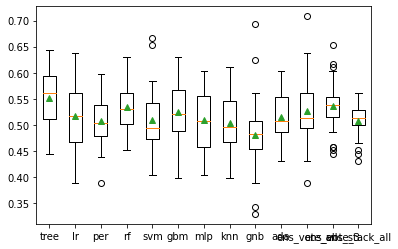

In [ ]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
accuracy_cv = [[names[i], mean(results[i])] for i in range(len(results))]
accuracy_cv

[['tree', 0.5103881278538813],
 ['lr', 0.5034436834094368],
 ['per', 0.5139459665144596],
 ['rf', 0.5236808726534753],
 ['svm', 0.5288368848300355],
 ['gbm', 0.49701927955352615],
 ['mlp', 0.512677574835109],
 ['knn', 0.48455098934551],
 ['gnb', 0.5094558599695586],
 ['ada', 0.5158105022831051],
 ['ens_vote_all', 0.5222856418061897],
 ['ens_vote_3', 0.5062214611872147]]

In [ ]:
accuracy_valid = [[names[i], acc_valid[i]] for i in range(len(results))]
accuracy_valid

[['tree', 0.5217391304347826],
 ['lr', 0.4673913043478261],
 ['per', 0.41304347826086957],
 ['rf', 0.4782608695652174],
 ['svm', 0.5],
 ['gbm', 0.4891304347826087],
 ['mlp', 0.5652173913043478],
 ['knn', 0.4782608695652174],
 ['gnb', 0.532608695652174],
 ['ada', 0.5217391304347826],
 ['ens_vote_all', 0.5],
 ['ens_vote_3', 0.4782608695652174]]

In [ ]:
# plot all confusion matrices
for i in range(0, len(models)):
    model_name = list(models.keys())[i]
    print('model', model_name, 'with accuracy', str(round(acc_valid[i]*100,4))+'%')
    model_confusion(y_valid, models[model_name].predict(X_valid))

## Feature Importances

Works only for those models that have coefficients that indicate feature importances (logistic regression, ridge regression...):

In [ ]:
feat_order = pd.DataFrame()
feat_order['feature'] = feature_subset(include='all')
feat_order['coef'] = models_cryptos['BTC']['reg']['all']['ridge'].best_estimator_.coef_
feat_order['coef_abs'] = abs(feat_order['coef'])

In [ ]:
feat_order.sort_values('coef_abs', ascending=False).head(10)

,feature,coef,coef_abs
34,volatility_kcc,3.413639,3.413639
54,trend_ema_slow,-1.802425,1.802425
126,market_cap_2,1.188971,1.188971
125,market_cap_1,1.175154,1.175154
36,volatility_kcl,-1.137160,1.137160
35,volatility_kch,-1.052931,1.052931
105,Close_2,-1.028090,1.028090
49,trend_macd_signal,-0.691762,0.691762
48,trend_macd,0.579450,0.579450
104,Close_1,-0.538630,0.538630


Model agnostic feature importances analysis using LIME:

In [ ]:
current_currency = 'BTC'
data, feat_remove = get_data()
train = data_filter(data, cur=[], source=[], date_min="2019-08-01", date_max="2021-07-31").dropna().reset_index(drop=True)
test = data_filter(data, cur=[], source=[], date_min="2021-08-01", date_max="2022-02-15").reset_index(drop=True)

In [ ]:
target_var = target

In [ ]:
feature_names_now = feature_subset(include='all')

X, y, X_test, y_test = model_data_pred(train, test, target_var, feature_names_now)
# X, y, X_test, y_test = model_data_pred(train, test, target_var, np.setdiff1d(feat_set_now, [feat for feat in feat_set_now if "weekday" in feat_set_now]))
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)
X_test = sc.transform(X_test)

In [ ]:
X.shape

(731, 145)

In [ ]:
len(feature_names_now)

145

In [ ]:
explainer = lime_tabular.LimeTabularExplainer(X, mode="regression",
                                              # class_names=['0', '1'],
                                              feature_names=feature_names_now)
explainer

In [ ]:
idx = random.randint(1, len(X_test))

explanation = explainer.explain_instance(X_test[idx], models_cryptos['BTC']['reg']['all']['ridge'].predict,
                                         num_features=len(feature_names_now))

explanation.show_in_notebook()

## Save Model Outputs

This is the part where one can save all the output models for future use.

In [ ]:
output.to_excel('/drive/My Drive/Colab Notebooks/final output/output_shiftwindow_btc_reg.xlsx', sheet_name = 'New_sheet')

In [ ]:
output, models_all, test_predictions, test_transactions

In [ ]:
import pickle

In [ ]:
#with open('/drive/My Drive/Colab Notebooks/final output/models_all_shiftwindow_btc_reg.pkl', 'wb') as f:
#   pickle.dump(models_all, f)

In [ ]:
with open('/drive/My Drive/Colab Notebooks/final output/results - shifting window/models_all_shiftwindow_eth_clf.pkl', 'rb') as f:
   models = pickle.load(f)

In [ ]:
cryptocurrency = "ETH"

is_regression = False
if is_regression:
    target_var = target
    model_type = "regression"
else:
    target_var = target_c
    model_type = "classification"

print(target_var)

train = data_filter(data, cur=[], source=[], date_min="2019-08-01", date_max="2021-07-31").dropna().reset_index(drop=True)
test = data_filter(data, cur=[], source=[], date_min="2021-08-01", date_max="2022-02-15").reset_index(drop=True)

return_tmr_classif


Do tests with some loaded models.. Not necessary, just my tests ----

In [ ]:
output_acc = pd.DataFrame()
train_trade = train.copy()
test_trade = test.copy()

In [ ]:
for feat_set, mod_list in models.items():
  X, y, X_test, y_test = model_data_pred(train, test, target_var, feature_subset(feat_set))
  sc = StandardScaler()
  sc.fit(X)
  X = sc.transform(X)
  X_test = sc.transform(X_test)
  for mod_name, mod in mod_list.items():
    train_pred = mod.predict(X)
    train_trade['y_pred'] = train_pred

    test_pred = mod.predict(X_test)
    test_trade['y_pred'] = test_pred
    if is_regression:
      tr_acc = regression_accuracy_score(train_trade, 'y_pred', target_var, 2)
      te_acc = regression_accuracy_score(test_trade, 'y_pred', target_var, 2)
    else:
      tr_acc = accuracy_score(train_trade['y_pred'], y)
      te_acc = accuracy_score(test_trade['y_pred'], y_test)
    
    output_acc = output_acc.append(pd.DataFrame({'cryptocurrency': [cryptocurrency],
                                            'model type': [model_type],
                                            'feature set': [feat_set],
                                            'model': [mod_name],
                                            'train accuracy': [tr_acc],
                                            'test accuracy': [te_acc]}))

In [ ]:
output_acc

,cryptocurrency,model type,feature set,model,train accuracy,test accuracy
0,BTC,classification,all,tree,0.713306,0.537688
0,BTC,classification,all,lr,0.710562,0.522613
0,BTC,classification,all,per,0.593964,0.492462
0,BTC,classification,all,rf,0.750343,0.547739
0,BTC,classification,all,svm,0.743484,0.557789
...,...,...,...,...,...,...
0,ETH,classification,only_sentiment,gnb,0.550069,0.517588
0,ETH,classification,only_sentiment,ada,0.727023,0.562814
0,ETH,classification,only_sentiment,ens_vote_all,0.758573,0.512563
0,ETH,classification,only_sentiment,ens_vote_3,0.659808,0.542714


In [ ]:
output = pd.read_excel("/drive/My Drive/output_shiftwindow_all.xlsx", index_col=None)

In [ ]:
output = output.merge(output_acc, on=['cryptocurrency','model type','model', 'feature set'])

In [ ]:
output.sort_values('gain scaled random', ascending=False).head(20)

,cryptocurrency,model type,model,feature set,train cv accuracy,test accuracy_x,input amount,trade period days,number of trade periods,output amount random,...,output amount predicted,gain scaled hold,t-test gain scaled hold,gain scaled random,t-test gain scaled random,output amount cost,num transactions,parameters,train accuracy,test accuracy_y
68,ETH,regression,ens_stack_all,no_sentiment,-0.003,0.603,1000,60,14,900.23 (271.94),...,1336.69 (340.91),0.286 (0.159),0.033,0.518 (0.157),0.00140,31.95 (7.73),13 (2),"{'cv': None, 'estimators': [('lr', Ridge(alpha...",0.540466,0.582915
65,ETH,classification,ens_vote_all,no_sentiment,0.515,0.538,1000,60,14,900.23 (271.94),...,1254.98 (154.77),0.255 (0.254),0.043,0.491 (0.328),0.00054,46.33 (11.0),20 (6),"{'estimators': [('lr', LogisticRegression(C=0....",0.847737,0.537688
1,BTC,classification,ada,no_sentiment,0.571,0.538,1000,60,14,805.18 (216.63),...,1114.01 (90.11),0.174 (0.286),0.270,0.465 (0.311),0.00018,27.47 (17.44),13 (8),"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.842250,0.537688
72,BTC,regression,svm,all,-0.003,0.548,1000,60,14,805.18 (216.63),...,1103.23 (86.17),0.171 (0.313),0.320,0.457 (0.334),0.00025,23.88 (22.58),11 (9),"{'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'd...",0.500686,0.547739
118,ETH,classification,knn,no_sentiment,0.489,0.548,1000,60,14,900.23 (271.94),...,1255.13 (263.05),0.225 (0.169),0.080,0.452 (0.216),0.00230,26.21 (10.93),12 (6),"{'algorithm': 'ball_tree', 'leaf_size': 40, 'm...",1.000000,0.547739
74,ETH,classification,ens_vote_all,all,0.513,0.553,1000,60,14,900.23 (271.94),...,1211.33 (158.07),0.212 (0.257),0.110,0.451 (0.365),0.00180,39.48 (10.3),17 (5),"{'estimators': [('lr', LogisticRegression(C=0....",0.790123,0.552764
60,ETH,classification,per,all,0.516,0.553,1000,60,14,900.23 (271.94),...,1196.32 (119.87),0.217 (0.316),0.130,0.449 (0.408),0.00210,34.28 (7.08),15 (3),"{'alpha': 0.0001, 'class_weight': None, 'early...",0.584362,0.552764
0,BTC,regression,lr,no_sentiment,-0.002,0.583,1000,60,14,805.18 (216.63),...,1103.3 (159.87),0.141 (0.228),0.360,0.431 (0.263),0.00054,40.31 (8.35),18 (4),"{'alpha': 1, 'copy_X': True, 'fit_intercept': ...",0.624143,0.582915
2,BTC,classification,tree,no_sentiment,0.514,0.518,1000,60,14,805.18 (216.63),...,1111.55 (205.83),0.131 (0.152),0.350,0.428 (0.219),0.00100,46.15 (6.35),21 (2),"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.695473,0.517588
5,BTC,regression,mlp,no_sentiment,-0.002,0.497,1000,60,14,805.18 (216.63),...,1069.32 (85.48),0.135 (0.314),0.550,0.424 (0.37),0.00077,21.19 (14.59),10 (7),"{'activation': 'relu', 'alpha': 0.0001, 'batch...",0.566529,0.497487


In [ ]:
output.to_excel('/drive/My Drive/Colab Notebooks/final output/output_shiftwindow_train_error_UPDATE.xlsx', sheet_name = 'New_sheet')

In [ ]:
temp['all']['ada']['window_2'].head(5)

,date,buy_sell,price,amount
0,2021-08-21,buy,48905.492188,0.020407
0,2021-08-25,sell,48960.789062,997.130170
0,2021-08-26,buy,46942.218750,0.021199
0,2021-08-27,sell,49058.667969,1037.922863
0,2021-08-28,buy,48902.402344,0.021182


## Model Parameter Space (Grid)

--- THIS IS NOT USED, SINCE BAYES SEARCH IS USED INSTEAD!

Parameter grids for all models to be used for hyperparameter tuning using cross-validated grid search.

Parameter grid for classification models

In [ ]:
param_grid_clf = {'model': {'lr': [LogisticRegression()],
                        'rf': [RandomForestClassifier()],
                        'svc': [SVC()],
                        'per': [Perceptron()],
                        'gbm': [GradientBoostingClassifier()],
                        'mlp': [MLPClassifier()],
                        'knn': [KNeighborsClassifier()],
                        'gnb': [GaussianNB()],
                        'ada': [AdaBoostClassifier()],
                        'tree': [DecisionTreeClassifier()]},
              'tree': {"splitter":["best","random"],
                       "max_depth" : [1,3,5,7,9,11,12],
                       "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
                       "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
                       "max_features":["auto","log2","sqrt",None],
                       "max_leaf_nodes":[None,5,10,20,30,40,50,60,70,80,90]},
              'lr':  {'C' : [100, 10, 1.0, 0.1, 0.01]},
              'per': {'max_iter':[100, 300, 500, 800, 1000, 1500], 
                      'eta0':[0.001, 0.01, 0.1, 1],
                      'solver' : ['liblinear', 'newton-cg', 'lbfgs']},
              'rf':  {'bootstrap': [True, False],
                      'max_depth': [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                      'max_features': ['auto', 'sqrt'],
                      'min_samples_leaf': [1, 2, 4, 8, 10, 12, 15],
                      'min_samples_split': [2, 5, 10],
                      'n_estimators': [200, 400, 500, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]},
              'svc': {'C': [100, 10, 1.0, 0.1, 0.01],
                      'gamma': ['auto', 'scale'],
                      'degree': [1,2,3,4,5,6,7,8],
                      'kernel': ['linear', 'poly', 'rbf']},
              'gbm': {"max_features": ["log2","sqrt"],
                      'learning_rate': [0.01,0.05,0.1,1,0.5],
                      'max_depth': [3,4,5],
                      'min_samples_leaf': [4,5,6,7,8,9,10],
                      'subsample': [0.6,0.7,0.8],
                      'n_estimators': [100,200,300,400,500]},
              'mlp': {'hidden_layer_sizes': [(5,10,20),(20,10,5,2)],
                      'activation': ['tanh', 'relu'],
                      'solver': ['sgd', 'adam', 'lbfgs'],
                      'alpha': [0.0001, 0.001, 0.05],
                      'learning_rate': ['constant','adaptive']},
              'knn': {'leaf_size': [1, 5, 10, 15, 20, 30, 40, 50, 60],
                      'n_neighbors': [2, 7, 10, 15, 20, 25, 35, 50],
                      'p':[1,2],
                      'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
              'gnb': {'priors': [None],
                      'var_smoothing': [1e-7, 1e-8, 1e-9, 1e-10]},
              'ada': {'n_estimators':[30, 50, 80, 100, 200], 
                      'learning_rate':[0.1, 0.5, 1.0]}
              }

Parameter grid for regression models

In [ ]:
param_grid_reg = {'model': {'ridge': [Ridge()],
                        'rf': [RandomForestRegressor()],
                        'svm': [SVR()],
                        'tree': [DecisionTreeRegressor()],
                        'gbm': [GradientBoostingRegressor()],
                        'mlp': [MLPRegressor()],
                        'knn': [KNeighborsRegressor()],
                        'ada': [AdaBoostRegressor()]},
              'tree': {"splitter":["best","random"],
                       "max_depth" : [1,3,5,7,9,11,12],
                       "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
                       "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                       "max_features":["auto","log2","sqrt",None],
                       "max_leaf_nodes":[None,5,10,20,30,40,50,60,70,80,90]},
              'ridge':  {'alpha' : [1,3,5,10,50,100]},
              'rf':  {'bootstrap': [True, False],
                      'criterion': ['squared_error', 'absolute_error'],
                      'max_depth': [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                      'max_features': ['auto', 'sqrt'],
                      'min_samples_leaf': [1, 2, 4, 8, 10, 12, 15],
                      'min_samples_split': [2, 5, 10],
                      'n_estimators': [200, 400, 500, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]},
              'svm': {'C': [100, 10, 1.0, 0.1, 0.01],
                      'gamma': ['auto', 'scale'],
                      'degree': [1,2,3,4,5,6,7,8],  # integer valued parameter
                      'kernel': ['linear', 'poly', 'rbf']},
              'gbm': {"max_features": ["log2","sqrt"],
                      'learning_rate': [0.01,0.05,0.1,1,0.5],
                      'max_depth': [3,4,5],
                      'min_samples_leaf': [4,5,6,7,8,9,10],
                      'subsample': [0.6,0.7,0.8],
                      'n_estimators': [100,200,300,400,500]},
              'mlp': {'hidden_layer_sizes': [(5,10,20),(20,10,5,2)],
                      'activation': ['tanh', 'relu', 'logistic'],
                      'solver': ['sgd', 'adam', 'lbfgs'],
                      'alpha': [0.0001, 0.001, 0.05],
                      'learning_rate': ['constant','adaptive'],
                      'learning_rate_init': [0.01, 0.1, 0.5, 1]},
              'knn': {'leaf_size': [1, 5, 10, 15, 20, 30, 40],
                      'n_neighbors': [2, 7, 10, 15, 20, 25, 35],
                      'p':[1,2],
                      'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
              'ada': {'n_estimators':[30, 50, 80, 100, 200], 
                      'learning_rate':[0.1, 0.5, 1.0]}
              }

## Model Parameter Space (Bayesian)

Bayesian hyperparameter optimization parameter list for all classification models in this work.

In [ ]:
param_grid_clf = {'model': {'lr': [LogisticRegression()],
                        'rf': [RandomForestClassifier()],
                        'svm': [SVC()],
                        'per': [Perceptron()],
                        'gbm': [GradientBoostingClassifier()],
                        'mlp': [MLPClassifier()],
                        'knn': [KNeighborsClassifier()],
                        'ada': [AdaBoostClassifier()],
                        'tree': [DecisionTreeClassifier()],
                        'xgb': [xgb.XGBClassifier(n_jobs = 1,
                                                objective = 'binary:logistic',
                                                eval_metric = 'auc',
                                                tree_method='approx')],
                        'lgbm': [lgb.LGBMClassifier(
                                  objective='binary')]},
              'tree': {'criterion': Categorical(['entropy']),
                       'splitter' :Categorical(["best"]),
                      #  'max_depth' : Integer(5,20),
                       'min_samples_leaf': Integer(3,10),
                      #  'min_weight_fraction_leaf' : Real(0.1,0.5),
                      #  'ccp_alpha': Real(1e-3, 1e-1, prior='log-uniform'),
                       'max_features' : Categorical(["auto","log2","sqrt"])},
              'lr':  {'C': Real(1e-6, 1e+6, prior='log-uniform')},
              'per': {'max_iter':Integer(100, 1200), 
                      'eta0': Real(1e-5, 1, prior='log-uniform'),
                      'class_weight': Categorical(['balanced']),
                      'penalty': Categorical(['l2']),
                      'alpha': Real(1e-5, 1e-3, prior='log-uniform'),
                      'random_state': Categorical([1,2,3,4,5,6,7,8])},
              'rf':  {'bootstrap': Categorical([True, False]),
                      'max_depth': Integer(4, 8),
                      # 'max_leaf_nodes': Integer(50, 300),
                      # 'min_samples_leaf': Integer(1,15),
                      'min_samples_split': Integer(2,10),
                      'max_features': Categorical(['auto', 'sqrt']),
                      # 'ccp_alpha': Real(1e-3, 1e-1, prior='log-uniform'),
                      'n_estimators': Integer(100,400),
                      'random_state': Categorical([1,2,3,4,5,6,7,8])},
              'svm': {'C': Real(1e-2, 1e1, prior='log-uniform'),
                      'kernel': Categorical(['linear', 'rbf', 'sigmoid']),
                      'gamma': Categorical(['scale', 'auto']),
                      'random_state': Categorical([1,2,3,4,5,6,7,8])},
              'gbm': {'max_features': Categorical(["auto", "log2"]),
                      'learning_rate': Real(0.1, 0.4, prior='uniform'),
                      'max_depth': Integer(2,4),
                      'min_samples_split': Integer(2,5),
                      'subsample': Real(0.6,0.8),
                      'n_estimators': Integer(70,110),
                      # 'ccp_alpha': Real(0, 0.2, prior='uniform'),
                      'random_state': Categorical([1,2,3,4,5,6,7,8])},
              'mlp': {'activation' : Categorical(['identity', 'logistic', 'tanh', 'relu']),
                      'solver' : Categorical(['lbfgs', 'sgd', 'adam']),
                      'alpha' : Real(1e-6, 1e-2, prior='log-uniform'),
                      'learning_rate' : Categorical(['constant', 'invscaling', 'adaptive']),
                      'max_iter' : Integer(100, 500),
                      'random_state': Categorical([1,2,3,4,5,6,7,8])},
              'knn': {'leaf_size': Integer(1,60),
                      'n_neighbors': Integer(2,50),
                      'p': Integer(1,2),
                      'algorithm': Categorical(['auto', 'ball_tree', 'kd_tree', 'brute'])},
              'ada': {'n_estimators': Integer(30, 200), 
                      'learning_rate': Real(0.1, 1.0, prior='log-uniform'),
                      'random_state': Categorical([1,2,3,4,5,6,7,8])},
              'xgb': {'learning_rate': Real(0.1, 0.4, prior='uniform'),
                      'gamma': Integer(1, 5),
                      'max_depth': Integer(1, 4),
                      # 'reg_lambda': Real(0, 1, prior='uniform'),
                      # 'reg_alpha': Real(0, 1, prior='uniform'),
                      'subsample': Real(0.5, 0.7, prior='uniform'),
                      'n_estimators': Integer(70, 110),
                      'random_state': Categorical([1,2,3,4,5,6,7,8])},
              'lgbm': {'learning_rate': Real(0.1, 0.4, prior='uniform'),
                      'num_leaves': Integer(4, 15),      
                      'max_depth': Integer(2, 4),
                      # 'min_child_samples': Integer(1, 50),
                      'num_iterations': Integer(70, 110),
                      'bagging_fraction': Real(0.5, 0.7, prior='uniform'),
                      # 'subsample_freq': Integer(0, 10),
                      # 'colsample_bytree': Real(0.01, 1.0, prior='uniform'),
                      # 'min_child_weight': Integer(0, 10),
                      # 'reg_lambda': Real(0, 1, prior='uniform'),
                      # 'reg_alpha': Real(0, 1, prior='uniform'),
                      # 'scale_pos_weight': Real(0.1, 500, prior='log-uniform'),
                      # 'n_estimators': Integer(50, 100),
                      'random_state': Categorical([1,2,3,4,5,6,7,8])}
              }

Bayesian hyperparameter optimization parameter list for all regression models in this work.

In [ ]:
param_grid_reg = {'model': {'ridge': [Ridge()],
                        'rf': [RandomForestRegressor()],
                        'svm': [SVR()],
                        'cat': [CatBoostRegressor(verbose=0)],
                        'gbm': [GradientBoostingRegressor()],
                        'mlp': [MLPRegressor()],
                        'sgd': [SGDRegressor()],
                        'ada': [AdaBoostRegressor()],
                        'tree': [DecisionTreeRegressor()],
                        'xgb': [xgb.XGBRegressor(n_jobs = 1,
                                                 objective = 'reg:squarederror',
                                                 tree_method='approx')],
                        'lgbm': [lgb.LGBMRegressor(objective='regression')]},
              'tree': {'splitter' :Categorical(["best"]),
                      #  'max_depth' : Integer(5,20),
                       'min_samples_leaf': Integer(3,10),
                      #  'ccp_alpha': Real(1e-3, 1e-1, prior='log-uniform'),
                       'max_features' : Categorical(["auto","log2","sqrt"])},
              'ridge':  {'alpha': Real(1e-6, 1e+6, prior='log-uniform')},
              'svm': {'C': Real(1e-2, 1e1, prior='log-uniform'),
                      'epsilon': Real(0.01, 0.5, prior='log-uniform'),
                      'kernel': Categorical(['linear', 'rbf', 'sigmoid']),
                      'gamma': Categorical(['scale', 'auto'])},
               'rf':  {'bootstrap': Categorical([True, False]),
                      'max_depth': Integer(4, 8),
                      # 'max_leaf_nodes': Integer(50, 300),
                      # 'min_samples_leaf': Integer(1,15),
                      'min_samples_split': Integer(2,10),
                      'max_features': Categorical(['auto', 'sqrt']),
                      # 'ccp_alpha': Real(1e-3, 1e-1, prior='log-uniform'),
                      'n_estimators': Integer(100,400),
                      'random_state': Categorical([1,2,3,4,5,6,7,8])},
              'cat': {'depth': Integer(2,4),
                      'l2_leaf_reg': Integer(10, 200),
                      'bagging_temperature': Integer(1, 100),
                      # 'border_count': Integer(3,255),
                      'rsm': Real(0.01, 1.0, prior='log-uniform')},
              'gbm': {'max_features': Categorical(["auto", "log2"]),
                      'learning_rate': Real(0.1, 0.4, prior='uniform'),
                      'max_depth': Integer(2,4),
                      'min_samples_split': Integer(2,5),
                      'n_estimators': Integer(70,110),
                      # 'ccp_alpha': Real(0, 0.2, prior='uniform'),
                      'random_state': Categorical([1,2,3,4,5,6,7,8])},
              'mlp': {'activation' : Categorical(['identity', 'tanh', 'relu']),
                      'solver' : Categorical(['lbfgs', 'sgd', 'adam']),
                      'alpha' : Real(1e-5, 1e-3, prior='log-uniform'),
                      'learning_rate' : Categorical(['constant', 'adaptive']),
                      'max_iter' : Integer(100, 500),
                      'random_state': Categorical([1,2,3,4,5,6,7,8])},
              'sgd': {'penalty': Categorical(['l1', 'l2', 'elasticnet']),
                      'alpha': Real(1e-5, 1e-3, prior='log-uniform'),
                      # 'eta0': Real(1e-3, 0.1, prior='log-uniform'),
                      'max_iter': Integer(600,1000),
                      'random_state': Categorical([1,2,3,4,5,6,7,8])},
              'ada': {'n_estimators': Integer(30, 200), 
                      'learning_rate': Real(0.1, 1.0, prior='log-uniform'),
                      'random_state': Categorical([1,2,3,4,5,6,7,8])},
              'xgb': {'learning_rate': Real(0.1, 0.4, prior='uniform'),
                      'gamma': Integer(1, 5),
                      'max_depth': Integer(1, 4),
                      # 'reg_lambda': Real(0, 1, prior='uniform'),
                      # 'reg_alpha': Real(0, 1, prior='uniform'),
                      'n_estimators': Integer(70, 110),
                      'random_state': Categorical([1,2,3,4,5,6,7,8])},
              'lgbm': {'learning_rate': Real(0.1, 0.4, prior='uniform'),
                      'num_leaves': Integer(4, 15),      
                      'max_depth': Integer(2, 4),
                      # 'min_child_samples': Integer(1, 50),
                      'num_iterations': Integer(70, 110),
                      # 'subsample_freq': Integer(0, 10),
                      # 'colsample_bytree': Real(0.01, 1.0, prior='uniform'),
                      # 'min_child_weight': Integer(0, 10),
                      # 'reg_lambda': Real(0, 1, prior='uniform'),
                      # 'reg_alpha': Real(0, 1, prior='uniform'),
                      # 'scale_pos_weight': Real(0.1, 500, prior='log-uniform'),
                      # 'n_estimators': Integer(50, 100),
                      'random_state': Categorical([1,2,3,4,5,6,7,8])}
              }

## Hyperparameter Tuning

Hyperparameter tuning is performed within the main pipeline, as defined by the functions in "Model Functions" part of this notebook. This section is only for manual trials to tune hyperparameters for a single model and see the output directly. This part is not run in the main code.

In [ ]:
current_currency = "BTC"
data, feat_remove = get_data()
train = data_filter(data, cur=[], source=[], date_min="2019-08-01", date_max="2021-07-31").dropna().reset_index(drop=True)
test = data_filter(data, cur=[], source=[], date_min="2021-08-01", date_max="2022-02-15").reset_index(drop=True)

In [ ]:
x_features = train.drop([target, target_c, *feat_remove], axis=1).columns
X, y, X_test, y_test = model_data_pred(train, test, target, x_features)

sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)
X_test = sc.transform(X_test)

In [ ]:
model = SGDRegressor(penalty='elasticnet', alpha=1, learning_rate='constant', eta0=100)
model.fit(X,y)

SGDRegressor(alpha=1, eta0=100, learning_rate='constant', penalty='elasticnet')

In [ ]:
y_pred = model.predict(X_test)
y_pred

In [ ]:
model_select = 'sgd'
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# clf = GridSearchCV(param_grid_clf['model'][model_select][0], param_grid = param_grid_clf[model_select], cv = 10, scoring='accuracy', verbose=1, n_jobs=-1)
# clf = RandomizedSearchCV(param_grid_clf['model'][model_select][0], param_grid_clf[model_select], n_iter=30, cv = 5, scoring='accuracy', verbose=1, n_jobs=-1)
opt = BayesSearchCV(param_grid_reg['model'][model_select][0], param_grid_reg[model_select], cv = cv, n_iter=10, 
                    # scoring='balanced_accuracy', 
                    scoring=custom_scoring_function, 
                    verbose=1, n_jobs=-1, random_state=123, refit=True)

opt.fit(X, y) # also fits a final model on the best hyperparameters

Fitting 15 folds for each of 1 candidates, totalling 15 fits
Fitting 15 folds for each of 1 candidates, totalling 15 fits
Fitting 15 folds for each of 1 candidates, totalling 15 fits
Fitting 15 folds for each of 1 candidates, totalling 15 fits
Fitting 15 folds for each of 1 candidates, totalling 15 fits
Fitting 15 folds for each of 1 candidates, totalling 15 fits
Fitting 15 folds for each of 1 candidates, totalling 15 fits
Fitting 15 folds for each of 1 candidates, totalling 15 fits
Fitting 15 folds for each of 1 candidates, totalling 15 fits
Fitting 15 folds for each of 1 candidates, totalling 15 fits


BayesSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=1),
              estimator=SGDRegressor(), n_iter=10, n_jobs=-1, random_state=123,
              scoring=<function custom_scoring_function at 0x7f7453d40830>,
              search_spaces={'alpha': Real(low=1e-05, high=0.001, prior='log-uniform', transform='normalize'),
                             'max_iter': Integer(low=600, high=1000, prior='uniform', transform='normalize'),
                             'penalty': Categorical(categories=('l1', 'l2', 'elasticnet'), prior=None),
                             'random_state': Categorical(categories=(1, 2, 3, ..., 6, 7, 8), prior=None)},
              verbose=1)

In [ ]:
opt.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__C', 'estimator__cache_size', 'estimator__coef0', 'estimator__degree', 'estimator__epsilon', 'estimator__gamma', 'estimator__kernel', 'estimator__max_iter', 'estimator__shrinking', 'estimator__tol', 'estimator__verbose', 'estimator', 'fit_params', 'iid', 'n_iter', 'n_jobs', 'n_points', 'optimizer_kwargs', 'pre_dispatch', 'random_state', 'refit', 'return_train_score', 'scoring', 'search_spaces', 'verbose'])

In [ ]:
opt.best_score_

0.530014001690043

In [ ]:
opt.score(X, y)

1.0

In [ ]:
opt.score(X_test, y_test) # same as fitting it on the whole train dataset

0.49619289340101524

In [ ]:
opt.best_params_

OrderedDict([('C', 20152.328648302442),
             ('degree', 4),
             ('gamma', 4.0953130757189096e-06),
             ('kernel', 'rbf'),
             ('random_state', 5)])

In [ ]:
y_pred = opt.predict(X_test)

In [ ]:
# accuracy_score(y_pred, y_test)
custom_scoring_function(opt, X_test, y_test)

0.507537688442211

In [ ]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

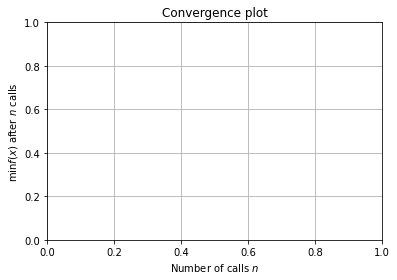

In [ ]:
plot_convergence(opt)

In [ ]:
model_search.best_score_

In [ ]:
model_search.best_params_

In [ ]:
model_search.best_estimator_.score(X_valid, y_valid)

0.532608695652174

In [ ]:
model_confusion(y_valid, best_clf.best_estimator_.predict(X_valid))

In [ ]:
X_test, y_test = test_data_prep(test, target_c, x_features)
X_test = sc.transform(X_test)
best_clf.best_estimator_.score(X_test, y_test)

0.5233644859813084

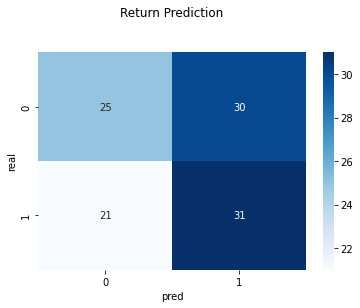

array([[25, 30],
       [21, 31]])

In [ ]:
model_confusion(y_test, best_clf.best_estimator_.predict(X_test))

## Further Calculations

These are just my tests as well. Nothing important ----

In [ ]:
#selected_models = models.copy()
selected_models = {sel_key: models[sel_key] for sel_key in ['rf','tree','gbm']}.copy()
y_pred_all = list()
for name, model in selected_models.items():
    y_pred = model.predict(X_valid)
    y_pred_all.append(y_pred)

In [ ]:
y_pred_ens = []
for i in range(len(y_pred_all[0])):
    y_pred = sum([item[i] for item in y_pred_all])
    y_pred_ens.append(y_pred)

y_pred_ens = discretize(y_pred_ens, thresh=[0.5,2.5], class_names=[0,0.5,1])

In [ ]:
compare = pd.DataFrame()
compare['y'] = y_valid
compare['y_pred'] = y_pred_ens

In [ ]:
compare = compare.loc[compare['y_pred']!=0.5]

In [ ]:
accuracy_score(compare['y_pred'], compare['y'])

0.5789473684210527

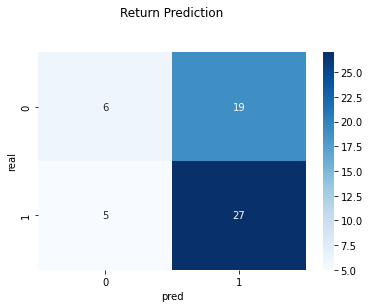

array([[ 6, 19],
       [ 5, 27]])

In [ ]:
model_confusion(compare['y'], compare['y_pred'])

In [ ]:
y_pred_ens = []
for i in range(len(y_pred_all[0])):
    y_pred = sum([item[i] for item in y_pred_all[:-2]])
    y_pred_ens.append(y_pred)

y_pred_ens = discretize(y_pred_ens, 4.9999, [0,1])
accuracy_score(y_pred_ens, y_valid)

0.5434782608695652

## Trading Simulation

These are all the functions that are used for performing the trading simulations.

Buy/sell function, given the amount, price, and transaction fee rate

In [ ]:
def trade_crypto(input_amount, price, buy_sell, loss_rate=0.0):
    
    if buy_sell=="buy":
        output_amount = input_amount/price*(1-loss_rate)
        cost_amount = input_amount*loss_rate
    elif buy_sell=="sell":
        output_amount = input_amount*price*(1-loss_rate)
        cost_amount = input_amount*price*loss_rate
    
    return float(output_amount), float(cost_amount)

Simple investment function. In a given trading period, buy when prices will increase and sell when price direction changes to decreasing.

In [ ]:
def invest_simple(input_amount, df, target_pred_var_name, trading_cost_rate=0.0):
    
    # take closing prices
    crypto_price = df['Close_0'].values
    predictions = df[target_pred_var_name].values
    date = df.date.values
    output_amount = input_amount
    have_crypto = False
    total_trading_costs = 0
    # build transaction log
    transaction_log = pd.DataFrame(columns=["date", "buy_sell", "price", "amount"])

    # different threshold for clf/reg models
    if is_regression:
        trade_decision_thresholds = [0,0]
    else:
        trade_decision_thresholds = [0.5,0.5]

    # for each prediction (meaning each day)
    for idx, pred in enumerate(predictions):
        
        # if you do not have crypto and prices increase tmr
        if pred>trade_decision_thresholds[0] and not(have_crypto):
            output_amount, cost = trade_crypto(output_amount, crypto_price[idx], "buy", trading_cost_rate)
            have_crypto = True
            transaction_log = transaction_log.append(pd.DataFrame(
                {"date":date[idx], "buy_sell":["buy"], "price":[crypto_price[idx]], "amount":[output_amount]}))
        # if you do have crypto and prices decrease tmr
        elif pred<trade_decision_thresholds[1] and have_crypto:
            output_amount, cost = trade_crypto(output_amount, crypto_price[idx], "sell", trading_cost_rate)
            have_crypto = False
            transaction_log = transaction_log.append(pd.DataFrame(
                {"date":date[idx], "buy_sell":["sell"], "price":[crypto_price[idx]], "amount":[output_amount]}))
        else:
            cost = 0
            
        total_trading_costs += cost
    
    # in the end, convert back to USD
    if have_crypto:
        output_amount, cost = trade_crypto(output_amount, crypto_price[-1], "sell", trading_cost_rate)
        have_crypto = False
        total_trading_costs += cost
        
    hold_scenario = crypto_price[-1]/crypto_price[0]*input_amount*(1-trading_cost_rate)**2
    
    return output_amount, total_trading_costs, transaction_log, hold_scenario

In [ ]:
# input_amount = 1000
# output_amount, cost, transaction_log, hold_scenario = invest_simple(input_amount, test, target_var)

In [ ]:
# transaction_log.head(5)

Plot the trading period simulation function

In [ ]:
def plot_trade_simulation(df_in, transact, plot_all):
    
    # whether you want to plot the whole period or just a subsection
    if not plot_all:
        df = df_in.loc[df_in['date'] <= transact.date.max()]
        df = df.loc[df['date'] >= transact.date.min()]
    else:
        df = df_in.copy()

    df['date_dt'] = df.date.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')).values
    transact['date_dt'] = transact.date.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')).values
    
    plt.rcParams['figure.figsize'] = [11, 5]
    plt.rcParams['figure.dpi'] = 100

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday=[1,15]))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 2, 8, 9, 10, 11, 12]))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))

    for i, xc in enumerate(transact.loc[transact.buy_sell=="buy"].date_dt):
        plt.axvline(x=xc, color='g', linestyle='--', linewidth=1, label='Buy' if i==0 else None)
    for i, xc in enumerate(transact.loc[transact.buy_sell=="sell"].date_dt):
        plt.axvline(x=xc, color='red', linestyle='--', linewidth=1, label='Sell' if i==0 else None)
    
    plt.plot(df.date_dt, df.Close_0, label='BTC Closing Price', color='black')
    plt.gcf().autofmt_xdate()
    
    plt.legend(loc="upper right")

    plt.xlabel('Date',fontsize=12)
    plt.ylabel('Price (USD)',fontsize=12)

    plt.savefig("simulation.svg")
    files.download("simulation.svg") 

    plt.show()

    return

Plot 'main'. Pick currency, model type, dates, input amount

In [ ]:
currencies = ['BTC']
is_regression = True
data, feat_remove = get_data()
train = data_filter(data, cur=[], source=[], date_min="2019-08-01", date_max="2021-07-31").dropna().reset_index(drop=True)
test = data_filter(data, cur=[], source=[], date_min="2021-08-01", date_max="2022-02-15").reset_index(drop=True)
target_var = target
input_amount = 1000
output_amount, cost, transaction_log, hold_scenario = invest_simple(input_amount, test, target_var)

In [ ]:
plt.rcParams.update({
    "font.family": "serif",   # specify font family here
    "font.serif": "Times",  # specify font here
    "font.size":11}) 

Plot simulation

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

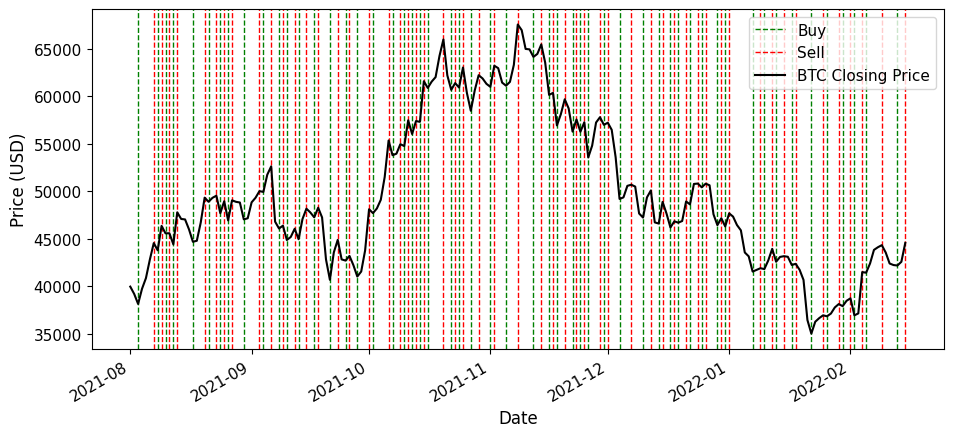

In [ ]:
plot_trade_simulation(test, transaction_log, True)

In [ ]:
# mod = models['no_sentiment']['ada']
# X, y, X_test, y_test = model_data_pred(train, test, target_var, feature_subset('no_sentiment'))
# sc = StandardScaler()
# sc.fit(X)
# X = sc.transform(X)
# X_test = sc.transform(X_test)
# test_trade = test.copy()
# test_pred = mod.predict(X_test)
# test_trade['y_pred'] = test_pred

In [ ]:
# output_amount, total_trading_costs, transaction_log, hold_scenario = invest_simple(1000, test_trade, 'y_pred', trading_cost_rate=0.002)

Multiple test periods simulation that creates a distribution. Repeats the shift_trade_simple() function with multiple test periods by shifting smaller periods within the main one,

In [ ]:
def shift_trade_window(input_amount, df, target_pred, target_real, day_delta, trade_duration, transaction_cost_ratio, model_name, feat_names):
    
    trade_duration -= 1
    delta = datetime.timedelta(days=day_delta)
    trade_period = datetime.timedelta(days=trade_duration)
    
    # create date object
    first_dt = datetime.datetime.strptime(df.date.min(), '%Y-%m-%d')
    last_dt = datetime.datetime.strptime(df.date.max(), '%Y-%m-%d')
    num_windows = int(np.floor(((last_dt-first_dt).days - trade_duration) / day_delta + 1))
    cur_dt = first_dt
    np.random.seed(123)
    random_decisions = np.random.choice([-1, 1], size=df.shape[0], p=[.5, .5])
    df['y_random'] = random_decisions # simulates random decision making. baseline

    col_names = ['start_date', 'end_date', 'input_amount', 'output_amount_random', 
                 'output_amount_ideal', 'hold_scenario', 
                 'output_amount_predicted', 'gain_scaled_hold', 'gain_scaled_random',
                 'cost_pred',
                 'num_transactions']
    trade_output = pd.DataFrame(columns = col_names)

    transactions_all = dict()
    
    # for each of the test periods
    for i in range(num_windows):
        end_dt = cur_dt + trade_period
        cur = datetime.datetime.strftime(cur_dt, '%Y-%m-%d')
        end = datetime.datetime.strftime(end_dt, '%Y-%m-%d')
        df_temp = data_filter(df, cur=[], source=[], date_min=cur, date_max=end)

        output_amount_pred, cost_pred, transaction_log, hold_sce = invest_simple(input_amount, df_temp, target_pred, transaction_cost_ratio)
        output_amount_random, cost, t_temp, hold_sce = invest_simple(input_amount, df_temp, 'y_random', transaction_cost_ratio)
        output_amount_ideal, cost, t_temp, hold_sce = invest_simple(input_amount, df_temp, target_real, transaction_cost_ratio)
        
        transactions_all['window_'+str(i)] = transaction_log

        # gain as a ratio to hold and random scenarios. as a distribution
        gain_scaled_hold = (output_amount_pred - hold_sce)/hold_sce
        gain_scaled_random = (output_amount_pred - output_amount_random)/output_amount_random

        trade_output_temp = pd.DataFrame(data=[[cur, end, input_amount, 
                                                output_amount_random, output_amount_ideal, hold_sce,
                                                output_amount_pred, gain_scaled_hold, gain_scaled_random,
                                                cost_pred,
                                                transaction_log.shape[0]]], columns=col_names)
        trade_output = trade_output.append(trade_output_temp).reset_index(drop=True)
        cur_dt = cur_dt + delta
    
    trade_output['trade_period_days'] = trade_duration+1
    
    ttest_random = stats.ttest_ind(a=trade_output['output_amount_predicted'], b=trade_output['output_amount_random'].values, equal_var=False).pvalue
    ttest_hold = stats.ttest_ind(a=trade_output['output_amount_predicted'], b=trade_output['hold_scenario'].values, equal_var=False).pvalue

    ttest_random = float('%.2g' % ttest_random)
    ttest_hold = float('%.2g' % ttest_hold)

    # prepare output table
    overall_output = pd.DataFrame([model_name], columns=['model'])
    overall_output['feature set'] = feat_names
    overall_output['input amount'] = input_amount
    overall_output['trade period_days'] = trade_duration+1
    overall_output['number of trade periods'] = num_windows
    overall_output['output amount random'] = find_mean_std(trade_output['output_amount_random'].values, 2)
    overall_output['output amount ideal'] = find_mean_std(trade_output['output_amount_ideal'].values, 2)
    overall_output['output amount buy and hold'] = find_mean_std(trade_output['hold_scenario'].values, 2)
    overall_output['output amount predicted'] = find_mean_std(trade_output['output_amount_predicted'].values, 2)
    overall_output['gain scaled hold'] = find_mean_std(trade_output['gain_scaled_hold'].values, 3)
    overall_output['t-test gain scaled hold'] = ttest_hold
    overall_output['gain scaled random'] = find_mean_std(trade_output['gain_scaled_random'].values, 3)
    overall_output['t-test gain scaled random'] = ttest_random
    overall_output['output amount cost'] = find_mean_std(trade_output['cost_pred'].values, 2)
    overall_output['num transactions'] = find_mean_std(trade_output['num_transactions'].values, 0, True)
    
    print("Output amount using",model_name, "predictions is", overall_output['output amount predicted'].values)

    return overall_output, transactions_all

In [ ]:
# out, tr = shift_trade_window(1000, test, target_var, target_var, 10, 60, 0.002, 'lr', 'all')

Find mean and standard deviation of a distribution function

In [ ]:
def find_mean_std(values, decimal_points, is_int=False):

    mean = round(np.mean(values),decimal_points)
    std = round(np.std(values),decimal_points)
    summary = str(mean) + " ("+str(std)+")"

    if is_int:
        summary = str(int(mean)) + " ("+str(int(std))+")"
    
    return summary

## Summarize Output Table

Summarizing the output tables by collectively observing them. Collect by crypto and model type for easy analysis

In [ ]:
data = pd.read_excel("/drive/My Drive/output_shiftwindow_all.xlsx", index_col=None)

In [ ]:
data = pd.read_excel("/drive/My Drive/output_summary_create.xlsx", index_col=None)

In [ ]:
data

,Cryptocurrency,Model Type,Model,Feature Set,Train CV Accuracy,Test Accuracy,Output Amount (USD),Gain Scaled by Hold Scenario,t-test Gain Scaled by Hold,Gain Scaled by Random Scenario,t-test Gain Scaled by Random,Total Trading Cost,Num Tran.
0,BTC,clf,ada,all,0.566,0.523,1042.53 (106.04),0.097 (0.273),0.77,0.374 (0.313),0.00220,34.29 (15.93),17 (8)
1,BTC,clf,ada,no sent.,0.571,0.538,1114.01 (90.11),0.174 (0.286),0.27,0.465 (0.311),0.00018,27.47 (17.44),13 (8)
2,BTC,clf,ada,only sent.,0.535,0.503,917.43 (167.84),-0.066 (0.124),0.30,0.175 (0.164),0.15000,54.2 (8.52),28 (2)
3,BTC,clf,stack (all),all,0.467,0.508,1017.42 (291.39),-0.0 (0.0),1.00,0.264 (0.139),0.04600,4.04 (0.58),1 (0)
4,BTC,clf,stack (all),no sent.,0.477,0.492,995.87 (310.54),-0.027 (0.04),0.86,0.232 (0.163),0.08200,45.23 (6.53),22 (2)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,ETH,reg,svm,no sent.,0.549,0.503,1052.23 (78.79),0.078 (0.314),0.96,0.284 (0.4),0.07200,14.23 (12.84),6 (6)
140,ETH,reg,svm,only sent.,0.524,0.482,917.76 (205.05),-0.113 (0.086),0.17,0.053 (0.131),0.85000,32.64 (7.27),16 (2)
141,ETH,reg,tree,all,0.538,0.492,1051.17 (298.59),-0.007 (0.026),0.96,0.179 (0.096),0.19000,4.27 (0.68),1 (1)
142,ETH,reg,tree,no sent.,0.458,0.457,941.31 (194.24),-0.08 (0.14),0.25,0.092 (0.186),0.66000,42.88 (14.69),21 (6)


In [ ]:
# data = data.loc[data['model'] != 'ens_vote_3'].reset_index(drop=True)

In [ ]:
data['Gain Scaled by Hold Scenario'] = data['Gain Scaled by Hold Scenario'].apply(lambda x: float(x.partition(' (')[0]))
data['Output Amount (USD)'] = data['Output Amount (USD)'].apply(lambda x: float(x.partition(' (')[0]))
data['Gain Scaled by Random Scenario'] = data['Gain Scaled by Random Scenario'].apply(lambda x: float(x.partition(' (')[0]))

In [ ]:
data

,Cryptocurrency,Model Type,Model,Feature Set,Train CV Accuracy,Test Accuracy,Output Amount (USD),Gain Scaled by Hold Scenario,t-test Gain Scaled by Hold,Gain Scaled by Random Scenario,t-test Gain Scaled by Random,Total Trading Cost,Num Tran.
0,BTC,clf,ada,all,0.566,0.523,1042.53,0.097,0.77,0.374,0.00220,34.29 (15.93),17 (8)
1,BTC,clf,ada,no sent.,0.571,0.538,1114.01,0.174,0.27,0.465,0.00018,27.47 (17.44),13 (8)
2,BTC,clf,ada,only sent.,0.535,0.503,917.43,-0.066,0.30,0.175,0.15000,54.2 (8.52),28 (2)
3,BTC,clf,stack (all),all,0.467,0.508,1017.42,-0.000,1.00,0.264,0.04600,4.04 (0.58),1 (0)
4,BTC,clf,stack (all),no sent.,0.477,0.492,995.87,-0.027,0.86,0.232,0.08200,45.23 (6.53),22 (2)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,ETH,reg,svm,no sent.,0.549,0.503,1052.23,0.078,0.96,0.284,0.07200,14.23 (12.84),6 (6)
140,ETH,reg,svm,only sent.,0.524,0.482,917.76,-0.113,0.17,0.053,0.85000,32.64 (7.27),16 (2)
141,ETH,reg,tree,all,0.538,0.492,1051.17,-0.007,0.96,0.179,0.19000,4.27 (0.68),1 (1)
142,ETH,reg,tree,no sent.,0.458,0.457,941.31,-0.080,0.25,0.092,0.66000,42.88 (14.69),21 (6)


In [ ]:
data_sel = data.loc[(data['cryptocurrency']==current_currency) & (data['model type']==model_type)]

Summary table:

In [ ]:
summary = pd.DataFrame()
for cur in np.unique(data['Cryptocurrency']):
  for mod in np.unique(data['Model Type']):
    for feat in ['all', 'no sent.']: #np.unique(data['feature set']):
      data_sel = data.loc[(data['Cryptocurrency']==cur) & (data['Model Type']==mod) & (data['Feature Set']==feat)]
      output_average = mean(data_sel['Output Amount (USD)'])
      hold_above_zero = mean(data_sel['Gain Scaled by Hold Scenario']>0)
      random_above_zero = mean(data_sel['Gain Scaled by Random Scenario']>0)
      t_value_hold_above_zero = mean(data_sel['t-test Gain Scaled by Hold']<=0.05)
      t_value_random_above_zero = mean(data_sel['t-test Gain Scaled by Random']<=0.05)
      summary = summary.append(pd.DataFrame({'cryptocurrency': [cur],
                                            'model type': [mod],
                                            'feature set': [feat],
                                            'mean train accuracy': [np.round(mean(data_sel['Train CV Accuracy']),3)],
                                            'mean test accuracy': [np.round(mean(data_sel['Test Accuracy']),3)],
                                            'mean output amount': [np.round(output_average,2)],
                                            'hold above zero': [np.round(hold_above_zero,3)],
                                            'significant hold': [np.round(t_value_hold_above_zero,3)],
                                            'random above zero': [np.round(random_above_zero,3)],
                                            'significant random': [np.round(t_value_random_above_zero,3)]}))

In [ ]:
summary

,cryptocurrency,model type,feature set,mean train accuracy,mean test accuracy,mean output amount,hold above zero,significant hold,random above zero,significant random
0,BTC,clf,all,0.526,0.520,983.64,0.615,0.000,1.000,0.692
0,BTC,clf,no sent.,0.522,0.518,998.48,0.692,0.077,1.000,0.769
0,BTC,reg,all,0.545,0.524,1012.89,0.636,0.000,1.000,0.909
0,BTC,reg,no sent.,0.553,0.518,1031.16,0.818,0.000,1.000,0.909
0,ETH,clf,all,0.512,0.521,1097.73,0.692,0.077,0.923,0.538
0,ETH,clf,no sent.,0.514,0.516,1101.26,0.769,0.077,1.000,0.462
0,ETH,reg,all,0.580,0.517,1061.84,0.727,0.000,1.000,0.182
0,ETH,reg,no sent.,0.564,0.515,1082.18,0.818,0.091,1.000,0.273


In [ ]:
summary.to_excel('/drive/My Drive/Colab Notebooks/financial_output_summary_TRAIN_UPDATE.xlsx', sheet_name = 'New_sheet')